In [ ]:
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

torch.set_default_dtype(torch.float64)


# -----------------------------
# Helpers: activations + derivs
# -----------------------------
def act(u: torch.Tensor, kind: str) -> torch.Tensor:
    if kind == "tanh":
        return torch.tanh(u)
    if kind == "relu":
        return torch.relu(u)
    if kind == "linear":
        return u
    raise ValueError(f"Unknown activation: {kind}")


def act_prime_from_u(u: torch.Tensor, kind: str) -> torch.Tensor:
    if kind == "tanh":
        a = torch.tanh(u)
        return 1.0 - a * a
    if kind == "relu":
        return (u > 0).to(u.dtype)
    if kind == "linear":
        return torch.ones_like(u)
    raise ValueError(f"Unknown activation: {kind}")


# -----------------------------
# Model definition (layerwise)
# -----------------------------
@dataclass
class MLP:
    Ws: List[torch.Tensor]
    bs: List[torch.Tensor]
    acts: List[str]

    @property
    def L(self) -> int:
        return len(self.Ws)

    @property
    def sizes(self) -> List[int]:
        return [self.Ws[0].shape[1]] + [W.shape[0] for W in self.Ws]


def forward_layerwise(net: MLP, x0: torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    a = x0
    zs, acts_out = [], []
    for W, b, k in zip(net.Ws, net.bs, net.acts):
        z = W @ a + b
        a = act(z, k)
        zs.append(z)
        acts_out.append(a)
    return zs, acts_out


# -----------------------------
# Packing/unpacking global state
# -----------------------------
def layer_slices(sizes: List[int]) -> List[slice]:
    idx = 0
    sl = []
    for n in sizes[1:]:
        sl.append(slice(idx, idx + n))
        idx += n
    return sl


def pack_layers(layers: List[torch.Tensor]) -> torch.Tensor:
    return torch.cat(layers, dim=0)


def unpack_global(v: torch.Tensor, sl: List[slice]) -> List[torch.Tensor]:
    return [v[s] for s in sl]


# -----------------------------
# Global operators without forming big W
# -----------------------------
def compute_u(net: MLP, x0: torch.Tensor, m_layers: List[torch.Tensor]) -> List[torch.Tensor]:
    u = []
    for l in range(net.L):
        inp = x0 if l == 0 else m_layers[l - 1]
        u.append(net.Ws[l] @ inp + net.bs[l])
    return u


def apply_WT_Ds(net: MLP, Ds_layers: List[torch.Tensor]) -> List[torch.Tensor]:
    L = net.L
    v = [torch.zeros_like(Ds_layers[l]) for l in range(L)]
    for j in range(1, L):
        v[j - 1] = v[j - 1] + net.Ws[j].T @ Ds_layers[j]
    return v


# -----------------------------
# Grad extraction from (m,s) readout
# -----------------------------
def relaxation_gradients(
    net: MLP,
    x0: torch.Tensor,
    m_layers: List[torch.Tensor],
    u_layers: List[torch.Tensor],
    s_layers: List[torch.Tensor],
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    deltas = []
    for l in range(net.L):
        D = act_prime_from_u(u_layers[l], net.acts[l])
        deltas.append(D * s_layers[l])

    dWs, dbs = [], []
    for l in range(net.L):
        inp = x0 if l == 0 else m_layers[l - 1]
        dWs.append(deltas[l].unsqueeze(1) @ inp.unsqueeze(0))
        dbs.append(deltas[l].clone())
    return dWs, dbs


def rel_error(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-12) -> float:
    return (torch.norm(a - b) / (torch.norm(b) + eps)).item()


# -----------------------------
# Baseline: autograd gradients
# -----------------------------
def autograd_gradients(net: MLP, x0: torch.Tensor, y: torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    Ws = [W.clone().detach().requires_grad_(True) for W in net.Ws]
    bs = [b.clone().detach().requires_grad_(True) for b in net.bs]
    tmp = MLP(Ws=Ws, bs=bs, acts=net.acts)

    _, a = forward_layerwise(tmp, x0)
    out = a[-1]
    loss = 0.5 * torch.sum((out - y) ** 2)
    loss.backward()

    dWs = [W.grad.detach().clone() for W in Ws]
    dbs = [b.grad.detach().clone() for b in bs]
    return dWs, dbs


# -----------------------------
# x-z relaxation (arbitrary eta) with CORRECTED step counting
# -----------------------------
@torch.no_grad()
def xz_relaxation(
    net: MLP,
    x0: torch.Tensor,
    y: torch.Tensor,
    eta: float,
    T: int = 5000,
    tol: float = 1e-12,
    log_every: int = 1,
) -> Dict[str, Any]:
    sizes = net.sizes
    sl = layer_slices(sizes)
    n_global = sum(sizes[1:])

    x = torch.zeros(n_global)
    z = torch.zeros(n_global)

    # reference gradients via standard backprop (needs grad enabled)
    with torch.enable_grad():
        dWs_bp, dbs_bp = autograd_gradients(net, x0, y)
    flat_bp_W = torch.cat([g.flatten() for g in dWs_bp])
    flat_bp_b = torch.cat([g.flatten() for g in dbs_bp])

    def embed_output_grad(gL: torch.Tensor) -> torch.Tensor:
        g = torch.zeros(n_global)
        g[sl[-1]] = gL
        return g

    # logs: step k means "after k Euler updates"
    steps: List[int] = []
    times: List[float] = []
    grad_err_W: List[float] = []
    grad_err_b: List[float] = []
    step_norms: List[float] = []

    def log_state(k: int):
        m = 0.5 * (x + z)
        s = (x - z)
        m_layers = unpack_global(m, sl)
        s_layers = unpack_global(s, sl)
        u_layers = compute_u(net, x0, m_layers)
        dWs_xz, dbs_xz = relaxation_gradients(net, x0, m_layers, u_layers, s_layers)

        flat_xz_W = torch.cat([g.flatten() for g in dWs_xz])
        flat_xz_b = torch.cat([g.flatten() for g in dbs_xz])

        steps.append(k)
        times.append(k * eta)
        grad_err_W.append(rel_error(flat_xz_W, flat_bp_W, eps=1e-18))
        grad_err_b.append(rel_error(flat_xz_b, flat_bp_b, eps=1e-18))

    # log initial state (k=0)
    log_state(0)

    k = 0
    while k < T:
        # compute RHS at current (x,z)
        m = 0.5 * (x + z)
        s = (x - z)

        m_layers = unpack_global(m, sl)
        s_layers = unpack_global(s, sl)

        u_layers = compute_u(net, x0, m_layers)
        sig_layers = [act(u_layers[l], net.acts[l]) for l in range(net.L)]
        sig = pack_layers(sig_layers)

        # loss gradient wrt mean output (MSE)
        mL = m_layers[-1]
        gL = (mL - y)
        g = embed_output_grad(gL)

        # coupling term W^T (D ⊙ s)
        Ds_layers = []
        for l in range(net.L):
            D = act_prime_from_u(u_layers[l], net.acts[l])
            Ds_layers.append(D * s_layers[l])
        WT_Ds = pack_layers(apply_WT_Ds(net, Ds_layers))

        dx = (sig - x) + 0.5 * WT_Ds + 0.5 * g
        dz = (sig - z) - 0.5 * WT_Ds - 0.5 * g

        x_next = x + eta * dx
        z_next = z + eta * dz

        sn = (torch.norm(x_next - x) + torch.norm(z_next - z)).item()
        step_norms.append(sn)

        x, z = x_next, z_next
        k += 1

        if (k % log_every) == 0:
            log_state(k)

        if sn < tol:
            break

    return {
        "eta": eta,
        "L": net.L,
        "steps": steps,
        "times": times,
        "grad_err_W": grad_err_W,
        "grad_err_b": grad_err_b,
        "step_norms": step_norms,   # length = number of updates performed
        "stop_step": k,             # EXACT number of Euler updates performed
        "stop_time": k * eta,
        "converged": (k < T),
    }


# -----------------------------
# Build a random MLP
# -----------------------------
def make_mlp(n0: int, hidden_width: int, hidden_layers: int, nL: int, seed: int = 0) -> MLP:
    g = torch.Generator().manual_seed(seed)
    sizes = [n0] + [hidden_width] * hidden_layers + [nL]
    L = len(sizes) - 1
    acts = ["tanh"] * (L - 1) + ["linear"]

    Ws, bs = [], []
    for l in range(1, len(sizes)):
        n_in, n_out = sizes[l - 1], sizes[l]
        W = 0.3 * torch.randn(n_out, n_in, generator=g)
        b = 0.1 * torch.randn(n_out, generator=g)
        Ws.append(W)
        bs.append(b)
    return MLP(Ws=Ws, bs=bs, acts=acts)


# -----------------------------
# Sweep many etas + plots
# -----------------------------
def main():
    torch.manual_seed(0)

    # fixed network
    n0, nL = 10, 5
    hidden_width = 32
    hidden_layers = 3  # => L = 4
    net = make_mlp(n0, hidden_width, hidden_layers, nL, seed=123)

    x0 = torch.randn(n0)
    y = torch.randn(nL)

    etas = [0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
    T = 20000
    tol = 1e-12

    results = []
    for eta in etas:
        # log more sparsely for small eta to keep plots light
        log_every = 50 if eta <= 0.05 else (10 if eta < 0.2 else 1)
        out = xz_relaxation(net, x0, y, eta=eta, T=T, tol=tol, log_every=log_every)
        results.append(out)
        print(
            f"eta={eta:g}  converged={out['converged']}  "
            f"stop_step={out['stop_step']}  stop_time={out['stop_time']:.3f}  "
            f"final relerrW={out['grad_err_W'][-1]:.3e}"
        )

    # Plot 1: gradient error vs steps (k = #updates)
    plt.figure()
    for out in results:
        plt.semilogy(out["steps"], out["grad_err_W"], marker="o", markersize=3, linewidth=1)
    plt.xlabel("Euler updates k")
    plt.ylabel("Relative gradient error (dW)")
    plt.title("x-z relaxation: gradient match vs updates (eta sweep)")
    plt.grid(True, which="both", linestyle=":")
    plt.legend([f"eta={out['eta']:g}" for out in results])

    # Plot 2: gradient error vs physical time t=eta*k
    plt.figure()
    for out in results:
        plt.semilogy(out["times"], out["grad_err_W"], marker="o", markersize=3, linewidth=1)
    plt.xlabel("Physical time t = eta * k")
    plt.ylabel("Relative gradient error (dW)")
    plt.title("x-z relaxation: gradient match vs physical time")
    plt.grid(True, which="both", linestyle=":")
    plt.legend([f"eta={out['eta']:g}" for out in results])

    # Plot 3: step norm vs update index (step_norms length = stop_step)
    plt.figure()
    for out in results:
        k = list(range(1, out["stop_step"] + 1))
        plt.semilogy(k, out["step_norms"], marker="o", markersize=2, linewidth=1)
    plt.xlabel("Euler update index")
    plt.ylabel("Step norm ||Δx|| + ||Δz||")
    plt.title("x-z relaxation: convergence residual vs updates")
    plt.grid(True, which="both", linestyle=":")
    plt.legend([f"eta={out['eta']:g}" for out in results])

    # Plot 4: steps-to-converge vs eta
    plt.figure()
    eta_ok = [out["eta"] for out in results if out["converged"]]
    steps_ok = [out["stop_step"] for out in results if out["converged"]]
    plt.plot(eta_ok, steps_ok, marker="o")
    plt.xlabel("eta")
    plt.ylabel("Updates to tol (k)")
    plt.title("Updates-to-converge vs eta")
    plt.grid(True, linestyle=":")

    # Plot 5: physical time to converge vs eta
    plt.figure()
    time_ok = [out["stop_time"] for out in results if out["converged"]]
    plt.plot(eta_ok, time_ok, marker="o")
    plt.xlabel("eta")
    plt.ylabel("Physical time to tol (eta * k)")
    plt.title("Physical convergence time vs eta")
    plt.grid(True, linestyle=":")

    plt.show()


if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataclasses import dataclass
from typing import List, Tuple
import matplotlib.pyplot as plt
import math


torch.set_default_dtype(torch.float32)


# -----------------------------
# Activations
# -----------------------------
def act(u: torch.Tensor, kind: str) -> torch.Tensor:
    if kind == "tanh":
        return torch.tanh(u)
    if kind == "relu":
        return torch.relu(u)
    if kind == "linear":
        return u
    raise ValueError(kind)


def act_prime_from_u(u: torch.Tensor, kind: str) -> torch.Tensor:
    if kind == "tanh":
        a = torch.tanh(u)
        return 1.0 - a * a
    if kind == "relu":
        return (u > 0).to(u.dtype)
    if kind == "linear":
        return torch.ones_like(u)
    raise ValueError(kind)


# -----------------------------
# Simple MLP container
# -----------------------------
@dataclass
class MLP:
    Ws: List[torch.Tensor]
    bs: List[torch.Tensor]
    acts: List[str]

    @property
    def L(self) -> int:
        return len(self.Ws)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        a = x
        for W, b, k in zip(self.Ws, self.bs, self.acts):
            a = act(a @ W.t() + b, k)
        return a


# -----------------------------
# xz relaxation for a batch
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: MLP,
    x0: torch.Tensor,            # (B, n0)
    y_onehot: torch.Tensor,      # (B, nL)
    eta: float = 0.1,
    K: int = 40,
) -> Tuple[List[torch.Tensor], List[torch.Tensor], float]:
    device = x0.device
    B = x0.shape[0]
    L = net.L

    x_layers = [torch.zeros(B, net.Ws[l].shape[0], device=device) for l in range(L)]
    z_layers = [torch.zeros_like(x_layers[l]) for l in range(L)]

    def compute_u_and_sig(m_layers):
        u_layers, sig_layers = [], []
        for l in range(L):
            inp = x0 if l == 0 else m_layers[l - 1]
            u = inp @ net.Ws[l].t() + net.bs[l]
            u_layers.append(u)
            sig_layers.append(act(u, net.acts[l]))
        return u_layers, sig_layers

    for _ in range(K):
        m_layers = [(x_layers[l] + z_layers[l]) * 0.5 for l in range(L)]
        s_layers = [x_layers[l] - z_layers[l] for l in range(L)]

        u_layers, sig_layers = compute_u_and_sig(m_layers)

        # --- Cross-entropy gradient wrt logits at output ---
        logits = m_layers[-1]
        p = torch.softmax(logits, dim=1)
        gL = (p - y_onehot)

        # q_l = D_l ⊙ s_l
        q_layers = []
        for l in range(L):
            D = act_prime_from_u(u_layers[l], net.acts[l])
            q_layers.append(D * s_layers[l])

        # WTq propagation: (WTq)_{l-1} += q_l @ W_l  (since q_l is row-batch)
        WTq_layers = [torch.zeros_like(q_layers[l]) for l in range(L)]
        for l in range(1, L):
            WTq_layers[l - 1] = WTq_layers[l - 1] + (q_layers[l] @ net.Ws[l])

        for l in range(L):
            g = gL if l == (L - 1) else 0.0
            dx = (sig_layers[l] - x_layers[l]) + 0.5 * WTq_layers[l] + 0.5 * g
            dz = (sig_layers[l] - z_layers[l]) - 0.5 * WTq_layers[l] - 0.5 * g
            x_layers[l] = x_layers[l] + eta * dx
            z_layers[l] = z_layers[l] + eta * dz

    # Readout gradients
    m_layers = [(x_layers[l] + z_layers[l]) * 0.5 for l in range(L)]
    s_layers = [x_layers[l] - z_layers[l] for l in range(L)]
    u_layers, _ = compute_u_and_sig(m_layers)

    deltas = []
    for l in range(L):
        D = act_prime_from_u(u_layers[l], net.acts[l])
        deltas.append(D * s_layers[l])

    dWs, dbs = [], []
    for l in range(L):
        inp = x0 if l == 0 else m_layers[l - 1]
        dW = torch.einsum("bi,bj->ij", deltas[l], inp) / B
        db = deltas[l].mean(dim=0)
        dWs.append(dW)
        dbs.append(db)

    # For logging only (not the optimized objective): CE value
    ce = -(y_onehot * torch.log(torch.softmax(m_layers[-1], dim=1) + 1e-12)).sum(dim=1).mean().item()
    return dWs, dbs, ce


# -----------------------------
# SGD with momentum + weight decay + clipping
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(
    net: MLP,
    dWs: List[torch.Tensor],
    dbs: List[torch.Tensor],
    vWs: List[torch.Tensor],
    vbs: List[torch.Tensor],
    lr: float,
    momentum: float = 0.9,
    weight_decay: float = 1e-4,
    clip: float = 1.0,
):
    # weight decay
    for l in range(net.L):
        dWs[l] = dWs[l] + weight_decay * net.Ws[l]

    # global grad norm clipping
    gn2 = 0.0
    for g in dWs:
        gn2 += float(g.norm() ** 2)
    for g in dbs:
        gn2 += float(g.norm() ** 2)
    gn = gn2 ** 0.5
    scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
    if scale != 1.0:
        dWs = [g * scale for g in dWs]
        dbs = [g * scale for g in dbs]

    # momentum update
    for l in range(net.L):
        vWs[l].mul_(momentum).add_(dWs[l])
        vbs[l].mul_(momentum).add_(dbs[l])
        net.Ws[l].sub_(lr * vWs[l])
        net.bs[l].sub_(lr * vbs[l])


@torch.no_grad()
def accuracy(net: MLP, loader: DataLoader, device: torch.device, max_batches: int = 200) -> float:
    correct = 0
    total = 0
    for i, (x, y) in enumerate(loader):
        if i >= max_batches:
            break
        x = x.to(device).view(x.size(0), -1)
        y = y.to(device)
        logits = net.forward(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def lr_schedule(epoch: int) -> float:
    # simple 3-phase schedule
    if epoch <= 10:
        return 0.01
    if epoch <= 20:
        return 0.005
    return 0.001


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # MLP: 784 -> 256 -> 256 -> 10
    n0, n1, n2, nL = 784, 256, 256, 10
    torch.manual_seed(0)

    init = 0.02
    W1 = init * torch.randn(n1, n0, device=device)
    b1 = torch.zeros(n1, device=device)
    W2 = init * torch.randn(n2, n1, device=device)
    b2 = torch.zeros(n2, device=device)
    W3 = init * torch.randn(nL, n2, device=device)
    b3 = torch.zeros(nL, device=device)

    net = MLP(Ws=[W1, W2, W3], bs=[b1, b2, b3], acts=["relu", "relu", "linear"])

    # momentum buffers
    vWs = [torch.zeros_like(W) for W in net.Ws]
    vbs = [torch.zeros_like(b) for b in net.bs]

    epochs = 15
    eta = 1  # xz-relaxation step size
    K = 40         # inner steps per batch
    momentum = 0.9
    weight_decay = 5e-4
    clip = 1.0

    train_ce_hist = []
    test_acc_hist = []
    step_hist = []
    epoch_acc_hist = []
    epoch_hist = []
    global_step = 0
    eval_every = 200


    for ep in range(1, epochs + 1):
        lr = lr_schedule(ep)
        running = 0.0

        for bi, (x, y) in enumerate(train_loader):
            x = x.to(device).view(x.size(0), -1)
            y = y.to(device)
            y_onehot = F.one_hot(y, num_classes=10).to(x.dtype)

            dWs, dbs, ce = xz_relax_batch_grad(net, x, y_onehot, eta=eta, K=K)
            sgd_momentum_step(
                net, dWs, dbs, vWs, vbs,
                lr=lr, momentum=momentum, weight_decay=weight_decay, clip=clip
            )


            global_step += 1
            train_ce_hist.append(ce)
            step_hist.append(global_step)

            if (global_step % eval_every) == 0:
                acc = accuracy(net, test_loader, device=device, max_batches=400)
                test_acc_hist.append(acc)
                print(f"step {global_step}: train-CE~{sum(train_ce_hist[-eval_every:])/eval_every:.4f}  test-acc={acc*100:.2f}%")


            running += ce
            if (bi + 1) % 200 == 0:
                acc = accuracy(net, test_loader, device=device, max_batches=200)
                print(f"epoch {ep:02d} batch {bi+1:04d}: CE={running/200:.4f}  lr={lr:.4g}  test-acc~{acc*100:.2f}%")
                running = 0.0

        epoch_hist.append(ep)
        epoch_acc_hist.append(acc)

        acc = accuracy(net, test_loader, device=device, max_batches=400)
        print(f"END epoch {ep:02d}: lr={lr:.4g}  test-acc~{acc*100:.2f}%")

    acc = accuracy(net, test_loader, device=device, max_batches=800)
    print(f"Final test-acc (approx): {acc*100:.2f}%")
    # ---- Plot 1: Train CE vs step (smoothed)
    plt.figure()
    # simple moving average
    win = 200
    if len(train_ce_hist) >= win:
        sm = [sum(train_ce_hist[i-win:i])/win for i in range(win, len(train_ce_hist)+1)]
        plt.plot(step_hist[win-1:], sm)
    else:
        plt.plot(step_hist, train_ce_hist)
    plt.xlabel("Update step")
    plt.ylabel("Train cross-entropy (moving avg)")
    plt.title("Training loss vs steps")
    plt.grid(True, linestyle=":")

    # ---- Plot 2: Test accuracy vs step
    plt.figure()
    eval_steps = [eval_every*(i+1) for i in range(len(test_acc_hist))]
    plt.plot(eval_steps, [100*a for a in test_acc_hist], marker="o")
    plt.xlabel("Update step")
    plt.ylabel("Test accuracy (%)")
    plt.title("Test accuracy vs steps")
    plt.grid(True, linestyle=":")

    # ---- Plot 3 (optional): Test accuracy vs epoch
    plt.figure()
    plt.plot(epoch_hist, [100*a for a in epoch_acc_hist], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Test accuracy (%)")
    plt.title("Test accuracy vs epoch")
    plt.grid(True, linestyle=":")

    plt.show()


    


if __name__ == "__main__":
    main()


In [3]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight


torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations``
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (3 conv + fc)
# -----------------------------
@dataclass
class CNN3:
    W1: torch.Tensor; b1: torch.Tensor   # (64,1,3,3)
    W2: torch.Tensor; b2: torch.Tensor   # (64,64,3,3)
    W3: torch.Tensor; b3: torch.Tensor   # (128,64,3,3) stride 2
    W4: torch.Tensor; b4: torch.Tensor   # (10, 128*14*14)

    @property
    def device(self): return self.W1.device


# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN3, x0, m1, m2, m3):
    # layer1 uses raw input
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1)  # (B,64,28,28)
    sig1 = relu(u1)

    # layer2 uses mean m1
    u2 = F.conv2d(m1, net.W2, net.b2, stride=1, padding=1)  # (B,64,28,28)
    sig2 = relu(u2)

    # layer3 uses mean m2
    u3 = F.conv2d(m2, net.W3, net.b3, stride=2, padding=1)  # (B,128,14,14)
    sig3 = relu(u3)

    # fc uses mean m3
    B = x0.shape[0]
    u4 = m3.reshape(B, -1) @ net.W4.t() + net.b4            # (B,10)
    sig4 = u4  # linear logits
    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4)

class XZState:
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None


# -----------------------------
# x-z relaxation gradient for batch
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN3, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
):
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    # -------------------------
    # Init / warm-start x,z
    # -------------------------
    def alloc():
        x1 = torch.zeros(B, 64, 28, 28, device=device); z1 = torch.zeros_like(x1)
        x2 = torch.zeros(B, 64, 28, 28, device=device); z2 = torch.zeros_like(x2)
        x3 = torch.zeros(B, 128, 14, 14, device=device); z3 = torch.zeros_like(x3)
        x4 = torch.zeros(B, 10, device=device);         z4 = torch.zeros_like(x4)
        return x1,z1,x2,z2,x3,z3,x4,z4

    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4
    else:
        x1,z1,x2,z2,x3,z3,x4,z4 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4

    # -------------------------
    # Relaxation loop
    # -------------------------
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1

        # mean/stress (avoid extra temporaries where possible)
        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

        (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4) = forward_u_sig(net, x0, m1, m2, m3)

        # CE grad wrt logits
        p = torch.softmax(m4, dim=1)
        g4 = (p - y_onehot)

        # q = D ⊙ s
        q2 = relu_prime(u2) * s2
        q3 = relu_prime(u3) * s3
        q4 = s4  # linear

        # W^T q propagation
        WTq3 = (q4 @ net.W4).reshape(B, 128, 14, 14)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=2, padding=1, output_padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=1, padding=1)

        # dynamics
        dx1 = (sig1 - x1) + 0.5 * WTq1
        dz1 = (sig1 - z1) - 0.5 * WTq1

        dx2 = (sig2 - x2) + 0.5 * WTq2
        dz2 = (sig2 - z2) - 0.5 * WTq2

        dx3 = (sig3 - x3) + 0.5 * WTq3
        dz3 = (sig3 - z3) - 0.5 * WTq3

        dx4 = (sig4 - x4) + 0.5 * g4
        dz4 = (sig4 - z4) - 0.5 * g4

        # Euler update
        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)

        # early stop (cheap criterion)
        # (avoid .item() too often; but once per iter is usually fine)
        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean()).item()
        if upd < tol:
            break

    # keep warm-start buffers for next batch
    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4

    # -------------------------
    # Final readout
    # -------------------------
    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

    (u1, _), (u2, _), (u3, _), (u4, _) = forward_u_sig(net, x0, m1, m2, m3)

    delta1 = relu_prime(u1) * s1
    delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3
    delta4 = s4

    # -------------------------
    # Faster weight grads (no unfold)
    # -------------------------
    # conv2d_weight computes sum over batch; divide by B for mean like before
    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=1, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=2, padding=1) / B

    db1 = delta1.mean(dim=(0,2,3))
    db2 = delta2.mean(dim=(0,2,3))
    db3 = delta3.mean(dim=(0,2,3))

    m3_flat = m3.reshape(B, -1)
    dW4 = (delta4.t() @ m3_flat) / B
    db4 = delta4.mean(dim=0)

    ce = F.cross_entropy(m4, y).item()

    # optionally return steps_taken so you can see average K used
    return (dW1,dW2,dW3,dW4), (db1,db2,db3,db4), ce, steps_taken


# -----------------------------
# SGD + momentum + wd + clip + EMA
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN3, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    dW1,dW2,dW3,dW4 = gradsW
    db1,db2,db3,db4 = gradsb

    # weight decay on weights only
    dW1 = dW1 + weight_decay * net.W1
    dW2 = dW2 + weight_decay * net.W2
    dW3 = dW3 + weight_decay * net.W3
    dW4 = dW4 + weight_decay * net.W4

    # global norm clip
    gn2 = float(dW1.norm()**2 + dW2.norm()**2 + dW3.norm()**2 + dW4.norm()**2 +
                db1.norm()**2 + db2.norm()**2 + db3.norm()**2 + db4.norm()**2)
    gn = gn2**0.5
    scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
    if scale != 1.0:
        dW1,dW2,dW3,dW4 = dW1*scale, dW2*scale, dW3*scale, dW4*scale
        db1,db2,db3,db4 = db1*scale, db2*scale, db3*scale, db4*scale

    # momentum buffers
    vW[0].mul_(momentum).add_(dW1); vb[0].mul_(momentum).add_(db1)
    vW[1].mul_(momentum).add_(dW2); vb[1].mul_(momentum).add_(db2)
    vW[2].mul_(momentum).add_(dW3); vb[2].mul_(momentum).add_(db3)
    vW[3].mul_(momentum).add_(dW4); vb[3].mul_(momentum).add_(db4)

    net.W1.sub_(lr * vW[0]); net.b1.sub_(lr * vb[0])
    net.W2.sub_(lr * vW[1]); net.b2.sub_(lr * vb[1])
    net.W3.sub_(lr * vW[2]); net.b3.sub_(lr * vb[2])
    net.W4.sub_(lr * vW[3]); net.b4.sub_(lr * vb[3])


@torch.no_grad()
def ema_update(ema_net: CNN3, net: CNN3, decay=0.999):
    for name in ["W1","b1","W2","b2","W3","b3","W4","b4"]:
        a = getattr(ema_net, name)
        b = getattr(net, name)
        a.mul_(decay).add_(b, alpha=(1.0 - decay))


@torch.no_grad()
def accuracy(net: CNN3, loader, device, max_batches=800):
    correct = 0
    total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)

        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=1, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=2, padding=1))
        logits = h3.reshape(x.size(0), -1) @ net.W4.t() + net.b4
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.02, lr_min=2e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # (optional but good for speed)
    torch.backends.cudnn.benchmark = True

    use_aug = True
    if use_aug:
        train_tfm = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        train_tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # model init
    torch.manual_seed(0)
    init = 0.02
    W1 = init * torch.randn(64, 1, 3, 3, device=device);   b1 = torch.zeros(64, device=device)
    W2 = init * torch.randn(64, 64, 3, 3, device=device);  b2 = torch.zeros(64, device=device)
    W3 = init * torch.randn(128, 64, 3, 3, device=device); b3 = torch.zeros(128, device=device)
    W4 = init * torch.randn(10, 128*14*14, device=device); b4 = torch.zeros(10, device=device)

    net = CNN3(W1,b1,W2,b2,W3,b3,W4,b4)
    ema_net = CNN3(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),W4.clone(),b4.clone())

    vW = [torch.zeros_like(net.W1), torch.zeros_like(net.W2), torch.zeros_like(net.W3), torch.zeros_like(net.W4)]
    vb = [torch.zeros_like(net.b1), torch.zeros_like(net.b2), torch.zeros_like(net.b3), torch.zeros_like(net.b4)]

    # hyperparams
    epochs = 12
    eta = 1
    K = 30
    tol = 1e-9        # <-- NEW: early-stop tolerance
    momentum = 0.9
    weight_decay = 5e-4
    clip = 1.0
    ema_decay = 0.999

    total_steps = epochs * len(train_loader)
    global_step = 0
    eval_every = 400

    ce_hist, acc_hist, step_hist = [], [], []

    # -------------------------
    # NEW: persistent warm-start buffers
    # -------------------------
    state = XZState()

    for ep in range(1, epochs+1):
        running = 0.0
        steps_sum = 0
        steps_count = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            lr = cosine_lr(global_step, total_steps, lr_max=0.02, lr_min=2e-4)

            # -------------------------
            # CHANGED CALL: now returns ce + steps_taken
            # -------------------------
            gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                net, x, y,
                eta=eta, K=K,
                state=state,
                tol=tol,
                warm_start=True
            )

            sgd_momentum_step(net, gradsW, gradsb, vW, vb,
                              lr=lr, momentum=momentum, weight_decay=weight_decay, clip=clip)

            ema_update(ema_net, net, decay=ema_decay)

            global_step += 1
            running += ce
            ce_hist.append(ce)
            step_hist.append(global_step)

            steps_sum += steps_taken
            steps_count += 1

            if global_step % eval_every == 0:
                acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
                acc_hist.append(acc)

                avgK = steps_sum / max(1, steps_count)
                print(f"step {global_step}: lr={lr:.4g}  train-CE~{running/eval_every:.4f}  "
                      f"EMA acc={acc*100:.2f}%  avg_relax_steps={avgK:.1f}")
                running = 0.0
                steps_sum = 0
                steps_count = 0

        acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
        print(f"END epoch {ep:02d}: EMA test-acc~{acc*100:.2f}%")

    final_acc = accuracy(ema_net, test_loader, device=device, max_batches=1200)
    print(f"Final EMA test-acc (approx): {final_acc*100:.2f}%")

    # plots
    plt.figure()
    win = 200
    if len(ce_hist) >= win:
        sm = [sum(ce_hist[i-win:i])/win for i in range(win, len(ce_hist)+1)]
        plt.plot(step_hist[win-1:], sm)
    else:
        plt.plot(step_hist, ce_hist)
    plt.xlabel("Update step")
    plt.ylabel("Train CE (moving avg)")
    plt.title("3-Conv CNN + x-z relaxation: training loss")
    plt.grid(True, linestyle=":")

    plt.figure()
    eval_steps = [eval_every*(i+1) for i in range(len(acc_hist))]
    plt.plot(eval_steps, [100*a for a in acc_hist], marker="o")
    plt.xlabel("Update step")
    plt.ylabel("Test accuracy (%)")
    plt.title("3-Conv CNN + x-z relaxation: EMA test accuracy")
    plt.grid(True, linestyle=":")

    plt.show()



if __name__ == "__main__":
    main()


device: cuda


step 400: lr=0.01976  train-CE~0.8341  EMA acc=79.43%  avg_relax_steps=30.0


KeyboardInterrupt: 

device: cuda
step 400: lr=0.01976  train-CE~0.8612  EMA acc=79.21%
END epoch 01: raw acc~95.84%  EMA acc~82.10%
step 800: lr=0.01903  train-CE~0.2244  EMA acc=93.29%
END epoch 02: raw acc~97.30%  EMA acc~95.06%
step 1200: lr=0.01786  train-CE~0.1341  EMA acc=96.85%
END epoch 03: raw acc~97.14%  EMA acc~97.47%
step 1600: lr=0.01631  train-CE~0.0808  EMA acc=97.97%
END epoch 04: raw acc~98.53%  EMA acc~98.36%
step 2000: lr=0.01445  train-CE~0.0450  EMA acc=98.47%
END epoch 05: raw acc~98.88%  EMA acc~98.67%
step 2400: lr=0.01237  train-CE~0.0170  EMA acc=98.68%
step 2800: lr=0.01018  train-CE~0.1119  EMA acc=98.84%
END epoch 06: raw acc~98.78%  EMA acc~98.87%
step 3200: lr=0.007989  train-CE~0.0970  EMA acc=98.97%
END epoch 07: raw acc~98.99%  EMA acc~99.03%
step 3600: lr=0.005899  train-CE~0.0713  EMA acc=99.03%
END epoch 08: raw acc~99.00%  EMA acc~99.05%
step 4000: lr=0.004019  train-CE~0.0518  EMA acc=99.08%
END epoch 09: raw acc~98.98%  EMA acc~99.10%
step 4400: lr=0.00244  train-CE

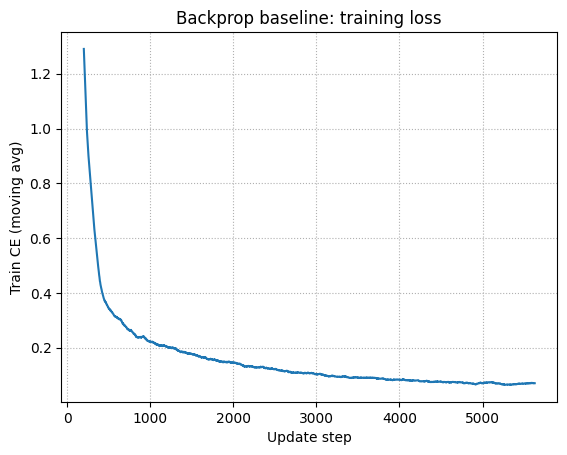

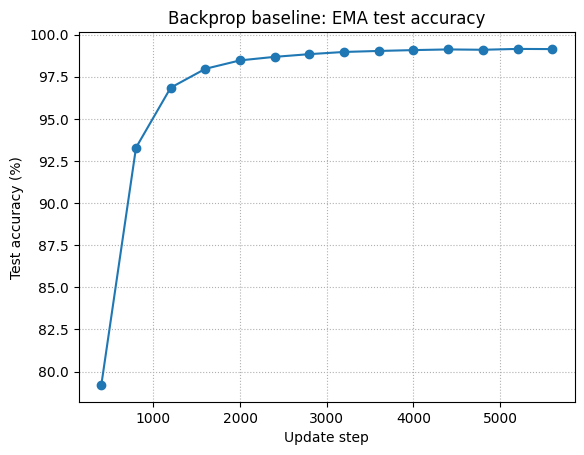

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

# -----------------------------
# Model (same architecture as your relaxation CNN3)
# -----------------------------
class CNN3BP(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 28->14
        self.fc    = nn.Linear(128 * 14 * 14, 10)

        # match your init scale roughly
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # logits
        return x


# -----------------------------
# EMA helper
# -----------------------------
@torch.no_grad()
def ema_update(ema_model: nn.Module, model: nn.Module, decay: float = 0.999):
    msd = model.state_dict()
    esd = ema_model.state_dict()
    for k in esd.keys():
        esd[k].mul_(decay).add_(msd[k], alpha=(1.0 - decay))
    ema_model.load_state_dict(esd)


@torch.no_grad()
def accuracy(model: nn.Module, loader: DataLoader, device, max_batches=1200) -> float:
    model.eval()
    correct = 0
    total = 0
    for i, (x, y) in enumerate(loader):
        if i >= max_batches:
            break
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.02, lr_min=2e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5 * (lr_max - lr_min) * (1.0 + math.cos(math.pi * t))


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # ---- data (match your setup) ----
    use_aug = True
    if use_aug:
        train_tfm = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        train_tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # ---- model ----
    torch.manual_seed(0)
    model = CNN3BP().to(device)
    ema_model = CNN3BP().to(device)
    ema_model.load_state_dict(model.state_dict())

    # ---- optimizer ----
    # match your "momentum + weight_decay"
    momentum = 0.9
    weight_decay = 5e-4
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=momentum, weight_decay=weight_decay)

    # ---- training ----
    epochs = 12
    total_steps = epochs * len(train_loader)
    global_step = 0
    eval_every = 400
    ema_decay = 0.999

    ce_hist, acc_hist, step_hist = [], [], []

    model.train()
    for ep in range(1, epochs + 1):
        running = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            lr = cosine_lr(global_step, total_steps, lr_max=0.02, lr_min=2e-4)
            for pg in optimizer.param_groups:
                pg["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()

            # optional: clip grad norm for fairness (your method uses clip=1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            ema_update(ema_model, model, decay=ema_decay)

            global_step += 1
            running += loss.item()
            ce_hist.append(loss.item())
            step_hist.append(global_step)

            if global_step % eval_every == 0:
                acc = accuracy(ema_model, test_loader, device=device, max_batches=800)
                acc_hist.append(acc)
                print(f"step {global_step}: lr={lr:.4g}  train-CE~{running/eval_every:.4f}  EMA acc={acc*100:.2f}%")
                running = 0.0

        acc_raw = accuracy(model, test_loader, device=device, max_batches=800)
        acc_ema = accuracy(ema_model, test_loader, device=device, max_batches=800)
        print(f"END epoch {ep:02d}: raw acc~{acc_raw*100:.2f}%  EMA acc~{acc_ema*100:.2f}%")

    final_raw = accuracy(model, test_loader, device=device, max_batches=1200)
    final_ema = accuracy(ema_model, test_loader, device=device, max_batches=1200)
    print(f"Final test acc: raw={final_raw*100:.2f}%  EMA={final_ema*100:.2f}%")

    # ---- plots (same as your relaxation script) ----
    plt.figure()
    win = 200
    if len(ce_hist) >= win:
        sm = [sum(ce_hist[i-win:i])/win for i in range(win, len(ce_hist)+1)]
        plt.plot(step_hist[win-1:], sm)
    else:
        plt.plot(step_hist, ce_hist)
    plt.xlabel("Update step")
    plt.ylabel("Train CE (moving avg)")
    plt.title("Backprop baseline: training loss")
    plt.grid(True, linestyle=":")

    plt.figure()
    eval_steps = [eval_every*(i+1) for i in range(len(acc_hist))]
    plt.plot(eval_steps, [100*a for a in acc_hist], marker="o")
    plt.xlabel("Update step")
    plt.ylabel("Test accuracy (%)")
    plt.title("Backprop baseline: EMA test accuracy")
    plt.grid(True, linestyle=":")

    plt.show()


if __name__ == "__main__":
    main()


GOOD SPED UP NORMAL DYNAMICS

device: cuda

Training with eta = 1.0

[eta=1.0 grad-compare step 0] cos(global W)=1.000000  normR(global W)=1.000000  relErr(global W)=0.000017
[eta=1.0 grad-compare step 200] cos(global W)=1.000000  normR(global W)=1.000002  relErr(global W)=0.000020
[eta=1.0] step 400: lr=0.01787  train-CE~0.8312  EMA acc=77.91%  avg_relax_steps=14.2
[eta=1.0 grad-compare step 400] cos(global W)=1.000000  normR(global W)=1.000005  relErr(global W)=0.000026
[eta=1.0] END epoch 01: EMA test-acc~82.93%
[eta=1.0 grad-compare step 600] cos(global W)=1.000000  normR(global W)=1.000004  relErr(global W)=0.000027
[eta=1.0] step 800: lr=0.01238  train-CE~0.2186  EMA acc=93.67%  avg_relax_steps=19.0
[eta=1.0 grad-compare step 800] cos(global W)=1.000000  normR(global W)=1.000003  relErr(global W)=0.000027
[eta=1.0] END epoch 02: EMA test-acc~95.41%
[eta=1.0 grad-compare step 1000] cos(global W)=1.000000  normR(global W)=1.000004  relErr(global W)=0.000023
[eta=1.0] step 1200: lr=0.005909  train-CE~0.1263  EMA

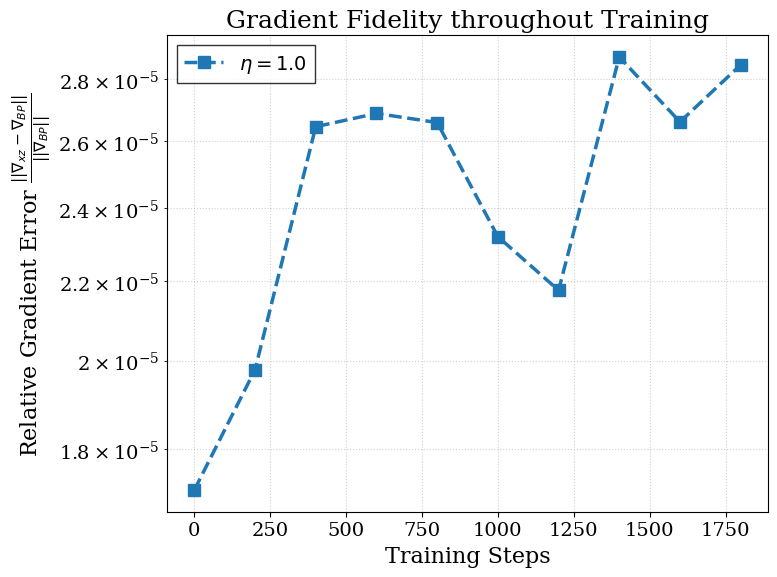

In [1]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (3 conv + fc)
# -----------------------------
@dataclass
class CNN3:
    W1: torch.Tensor; b1: torch.Tensor   # (64,1,3,3)
    W2: torch.Tensor; b2: torch.Tensor   # (64,64,3,3)
    W3: torch.Tensor; b3: torch.Tensor   # (128,64,3,3) stride 2
    W4: torch.Tensor; b4: torch.Tensor   # (10, 128*14*14)

    @property
    def device(self): return self.W1.device


# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN3, x0, m1, m2, m3):
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1)  # (B,64,28,28)
    sig1 = relu(u1)

    u2 = F.conv2d(m1, net.W2, net.b2, stride=1, padding=1)  # (B,64,28,28)
    sig2 = relu(u2)

    u3 = F.conv2d(m2, net.W3, net.b3, stride=2, padding=1)  # (B,128,14,14)
    sig3 = relu(u3)

    B = x0.shape[0]
    u4 = m3.reshape(B, -1) @ net.W4.t() + net.b4            # (B,10)
    sig4 = u4  # linear logits
    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4)

class XZState:
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None


# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN3, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    def alloc():
        x1 = torch.zeros(B, 64, 28, 28, device=device); z1 = torch.zeros_like(x1)
        x2 = torch.zeros(B, 64, 28, 28, device=device); z2 = torch.zeros_like(x2)
        x3 = torch.zeros(B, 128, 14, 14, device=device); z3 = torch.zeros_like(x3)
        x4 = torch.zeros(B, 10, device=device);         z4 = torch.zeros_like(x4)
        return x1,z1,x2,z2,x3,z3,x4,z4

    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4
    else:
        x1,z1,x2,z2,x3,z3,x4,z4 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4

    steps_taken = 0
    for _ in range(K):
        steps_taken += 1

        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

        (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4) = forward_u_sig(net, x0, m1, m2, m3)

        F1 = sig1 - m1
        F2 = sig2 - m2
        F3 = sig3 - m3
        F4 = sig4 - m4

        p = torch.softmax(m4, dim=1)
        g4 = (p - y_onehot)

        q2 = relu_prime(u2) * s2
        q3 = relu_prime(u3) * s3
        q4 = s4

        WTq3 = (q4 @ net.W4).reshape(B, 128, 14, 14)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=2, padding=1, output_padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=1, padding=1)

        Jt1 = -s1 + WTq1
        Jt2 = -s2 + WTq2
        Jt3 = -s3 + WTq3
        Jt4 = -s4

        dx1 = F1 + 0.5 * Jt1
        dz1 = F1 - 0.5 * Jt1

        dx2 = F2 + 0.5 * Jt2
        dz2 = F2 - 0.5 * Jt2

        dx3 = F3 + 0.5 * Jt3
        dz3 = F3 - 0.5 * Jt3

        dx4 = F4 + 0.5 * Jt4 + 0.5 * beta * g4
        dz4 = F4 - 0.5 * Jt4 - 0.5 * beta * g4

        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)

        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean()).item()
        if upd < tol:
            break

    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4

    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

    (u1, _), (u2, _), (u3, _), (_, _) = forward_u_sig(net, x0, m1, m2, m3)

    delta1 = relu_prime(u1) * s1
    delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3
    delta4 = s4

    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=1, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=2, padding=1) / B

    # IMPORTANT FIX: match PyTorch bias grad normalization (sum spatial, avg batch)
    db1 = delta1.sum(dim=(0,2,3)) / B
    db2 = delta2.sum(dim=(0,2,3)) / B
    db3 = delta3.sum(dim=(0,2,3)) / B

    m3_flat = m3.reshape(B, -1)
    dW4 = (delta4.t() @ m3_flat) / B
    db4 = delta4.mean(dim=0)

    ce = F.cross_entropy(m4, y).item()
    return (dW1,dW2,dW3,dW4), (db1,db2,db3,db4), ce, steps_taken


# -----------------------------
# SGD + momentum + wd + clip + EMA
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN3, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    dW1,dW2,dW3,dW4 = gradsW
    db1,db2,db3,db4 = gradsb

    dW1 = dW1 + weight_decay * net.W1
    dW2 = dW2 + weight_decay * net.W2
    dW3 = dW3 + weight_decay * net.W3
    dW4 = dW4 + weight_decay * net.W4

    gn2 = float(dW1.norm()**2 + dW2.norm()**2 + dW3.norm()**2 + dW4.norm()**2 +
                db1.norm()**2 + db2.norm()**2 + db3.norm()**2 + db4.norm()**2)
    gn = gn2**0.5
    scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
    if scale != 1.0:
        dW1,dW2,dW3,dW4 = dW1*scale, dW2*scale, dW3*scale, dW4*scale
        db1,db2,db3,db4 = db1*scale, db2*scale, db3*scale, db4*scale

    vW[0].mul_(momentum).add_(dW1); vb[0].mul_(momentum).add_(db1)
    vW[1].mul_(momentum).add_(dW2); vb[1].mul_(momentum).add_(db2)
    vW[2].mul_(momentum).add_(dW3); vb[2].mul_(momentum).add_(db3)
    vW[3].mul_(momentum).add_(dW4); vb[3].mul_(momentum).add_(db4)

    net.W1.sub_(lr * vW[0]); net.b1.sub_(lr * vb[0])
    net.W2.sub_(lr * vW[1]); net.b2.sub_(lr * vb[1])
    net.W3.sub_(lr * vW[2]); net.b3.sub_(lr * vb[2])
    net.W4.sub_(lr * vW[3]); net.b4.sub_(lr * vb[3])


@torch.no_grad()
def ema_update(ema_net: CNN3, net: CNN3, decay=0.999):
    for name in ["W1","b1","W2","b2","W3","b3","W4","b4"]:
        a = getattr(ema_net, name)
        b = getattr(net, name)
        a.mul_(decay).add_(b, alpha=(1.0 - decay))


@torch.no_grad()
def accuracy(net: CNN3, loader, device, max_batches=800):
    correct = 0
    total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)

        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=1, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=2, padding=1))
        logits = h3.reshape(x.size(0), -1) @ net.W4.t() + net.b4
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.02, lr_min=2e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))


# -----------------------------
# Autograd gradient (reference)
# -----------------------------
def autograd_grads_like(net: CNN3, x, y):
    # make differentiable copies (leaf tensors)
    W1 = net.W1.detach().clone().requires_grad_(True)
    b1 = net.b1.detach().clone().requires_grad_(True)
    W2 = net.W2.detach().clone().requires_grad_(True)
    b2 = net.b2.detach().clone().requires_grad_(True)
    W3 = net.W3.detach().clone().requires_grad_(True)
    b3 = net.b3.detach().clone().requires_grad_(True)
    W4 = net.W4.detach().clone().requires_grad_(True)
    b4 = net.b4.detach().clone().requires_grad_(True)

    h1 = relu(F.conv2d(x, W1, b1, stride=1, padding=1))
    h2 = relu(F.conv2d(h1, W2, b2, stride=1, padding=1))
    h3 = relu(F.conv2d(h2, W3, b3, stride=2, padding=1))
    logits = h3.reshape(x.size(0), -1) @ W4.t() + b4

    loss = F.cross_entropy(logits, y)  # mean over batch
    loss.backward()

    gradsW = (W1.grad, W2.grad, W3.grad, W4.grad)
    gradsb = (b1.grad, b2.grad, b3.grad, b4.grad)
    return gradsW, gradsb, float(loss.detach())


def flat_cat(tup):
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def norm_ratio(a, b, eps=1e-12):
    return float(a.norm() / b.norm().clamp_min(eps))

def relative_error(a, b, eps=1e-12):
    """Compute ||a - b|| / ||b||"""
    return float((a - b).norm() / b.norm().clamp_min(eps))


# ---------------------------------------------------------
# PLOTTING FUNCTION FOR ICML (ADDED)
# ---------------------------------------------------------
def plot_results_icml(results, eta_values):
    """
    Generates a publication-quality plot for ICML/NeurIPS.
    Focus: Global Relative Error between Relaxed Gradients and Autograd.
    """
    # Configure Matplotlib for LaTeX-like aesthetics
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
        "figure.figsize": (8, 6),
        "text.usetex": False, # Set to True if you have local LaTeX installed
    })

    plt.figure()
    
    # Define styles for different eta values
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        # Add more if needed
    }

    for eta in eta_values:
        if eta not in results: continue
        
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        
        if len(cos_steps) == 0: continue

        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        
        plt.plot(cos_steps, rel_err, 
                 label=fr'$\eta={eta}$', 
                 color=style['color'], 
                 marker=style['marker'], 
                 linestyle=style['linestyle'])

    # Log scale is crucial for relative error plots
    plt.yscale('log')
    
    plt.xlabel('Training Steps')
    # Formal mathematical label
    plt.ylabel(r'Relative Gradient Error $\frac{||\nabla_{xz} - \nabla_{BP}||}{||\nabla_{BP}||}$')
    plt.title('Gradient Fidelity throughout Training')
    
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend(frameon=True, fancybox=False, edgecolor='k')
    
    plt.tight_layout()
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    torch.backends.cudnn.benchmark = True

    use_aug = True
    if use_aug:
        train_tfm = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        train_tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    epochs = 4
    K = 30
    tol = 1e-6
    momentum = 0.9
    weight_decay = 5e-4
    clip = 1.0
    ema_decay = 0.999

    eval_every = 400
    compare_every = 200

    # -------------------------
    # Test different eta values
    # -------------------------
    eta_values = [1.0]
    layer_names = ["W1","b1","W2","b2","W3","b3","W4","b4"]
    
    # Store results for each eta
    results = {}
    
    for eta in eta_values:
        print(f"\n{'='*60}")
        print(f"Training with eta = {eta}")
        print(f"{'='*60}\n")
        
        # Reset network for fair comparison
        torch.manual_seed(0)
        init = 0.02
        W1 = init * torch.randn(64, 1, 3, 3, device=device);   b1 = torch.zeros(64, device=device)
        W2 = init * torch.randn(64, 64, 3, 3, device=device);  b2 = torch.zeros(64, device=device)
        W3 = init * torch.randn(128, 64, 3, 3, device=device); b3 = torch.zeros(128, device=device)
        W4 = init * torch.randn(10, 128*14*14, device=device); b4 = torch.zeros(10, device=device)

        net = CNN3(W1,b1,W2,b2,W3,b3,W4,b4)
        ema_net = CNN3(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),W4.clone(),b4.clone())

        vW = [torch.zeros_like(net.W1), torch.zeros_like(net.W2), torch.zeros_like(net.W3), torch.zeros_like(net.W4)]
        vb = [torch.zeros_like(net.b1), torch.zeros_like(net.b2), torch.zeros_like(net.b3), torch.zeros_like(net.b4)]

        total_steps = epochs * len(train_loader)
        global_step = 0

        ce_hist, acc_hist, step_hist = [], [], []

        # Gradient comparison histories
        cos_globalW_hist = []
        cos_layer_hist = {name: [] for name in layer_names}
        cos_steps = []

        norm_globalW_hist = []
        norm_layer_hist = {name: [] for name in layer_names}

        relerr_globalW_hist = []
        relerr_layer_hist = {name: [] for name in layer_names}

        state = XZState()

        for ep in range(1, epochs+1):
            running = 0.0
            steps_sum = 0
            steps_count = 0

            for x, y in train_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

                lr = cosine_lr(global_step, total_steps, lr_max=0.02, lr_min=2e-4)

                # xz gradients
                gradsW_xz, gradsb_xz, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y,
                    eta=eta, K=K,
                    state=state,
                    tol=tol,
                    warm_start=True
                )

                # autograd gradients (reference) every compare_every
                if global_step % compare_every == 0:
                    gradsW_ag, gradsb_ag, ce_ag = autograd_grads_like(net, x, y)

                    # global weights cosine + norm ratio + relative error (W only)
                    gx = flat_cat(gradsW_xz)
                    ga = flat_cat(gradsW_ag)

                    cos_globalW_hist.append(cos_sim(gx, ga))
                    norm_globalW_hist.append(norm_ratio(gx, ga))
                    relerr_globalW_hist.append(relative_error(gx, ga))  # ADDED
                    cos_steps.append(global_step)

                    # per-layer + bias cosine + norm ratios + relative errors
                    xz_all = {
                        "W1": gradsW_xz[0], "W2": gradsW_xz[1], "W3": gradsW_xz[2], "W4": gradsW_xz[3],
                        "b1": gradsb_xz[0], "b2": gradsb_xz[1], "b3": gradsb_xz[2], "b4": gradsb_xz[3],
                    }
                    ag_all = {
                        "W1": gradsW_ag[0], "W2": gradsW_ag[1], "W3": gradsW_ag[2], "W4": gradsW_ag[3],
                        "b1": gradsb_ag[0], "b2": gradsb_ag[1], "b3": gradsb_ag[2], "b4": gradsb_ag[3],
                    }
                    for name in layer_names:
                        cos_layer_hist[name].append(cos_sim(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))
                        norm_layer_hist[name].append(norm_ratio(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))
                        relerr_layer_hist[name].append(relative_error(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))  # ADDED

                    print(
                        f"[eta={eta} grad-compare step {global_step}] "
                        f"cos(global W)={cos_globalW_hist[-1]:.6f}  "
                        f"normR(global W)={norm_globalW_hist[-1]:.6f}  "
                        f"relErr(global W)={relerr_globalW_hist[-1]:.6f}"  # ADDED
                    )

                # update
                sgd_momentum_step(net, gradsW_xz, gradsb_xz, vW, vb,
                                  lr=lr, momentum=momentum, weight_decay=weight_decay, clip=clip)

                ema_update(ema_net, net, decay=ema_decay)

                global_step += 1
                running += ce
                ce_hist.append(ce)
                step_hist.append(global_step)

                steps_sum += steps_taken
                steps_count += 1

                if global_step % eval_every == 0:
                    acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
                    acc_hist.append(acc)

                    avgK = steps_sum / max(1, steps_count)
                    print(f"[eta={eta}] step {global_step}: lr={lr:.4g}  train-CE~{running/eval_every:.4f}  "
                          f"EMA acc={acc*100:.2f}%  avg_relax_steps={avgK:.1f}")
                    running = 0.0
                    steps_sum = 0
                    steps_count = 0

            acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
            print(f"[eta={eta}] END epoch {ep:02d}: EMA test-acc~{acc*100:.2f}%")

        final_acc = accuracy(ema_net, test_loader, device=device, max_batches=1200)
        print(f"[eta={eta}] Final EMA test-acc (approx): {final_acc*100:.2f}%")
        
        # Store results for this eta
        results[eta] = {
            'ce_hist': ce_hist,
            'acc_hist': acc_hist,
            'step_hist': step_hist,
            'cos_globalW_hist': cos_globalW_hist,
            'cos_layer_hist': cos_layer_hist.copy(),
            'cos_steps': cos_steps,
            'norm_globalW_hist': norm_globalW_hist,
            'norm_layer_hist': norm_layer_hist.copy(),
            'relerr_globalW_hist': relerr_globalW_hist,
            'relerr_layer_hist': relerr_layer_hist.copy(),
            'final_acc': final_acc,
        }

    # -------------------------
    # CALL THE ICML PLOTTING FUNCTION
    # -------------------------
    print("\nGenerating ICML publication-quality plot...")
    plot_results_icml(results, eta_values)


if __name__ == "__main__":
    main()

In [3]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (modern CNN for CIFAR-10)
# Architecture: 3 conv blocks with batch norm-like scaling + fc
# Input: 32x32x3 -> Output: 10 classes
# -----------------------------
@dataclass
class CNN_CIFAR10:
    W1: torch.Tensor; b1: torch.Tensor   # (64,3,3,3) stride 1 pad 1 -> 32x32x64
    W2: torch.Tensor; b2: torch.Tensor   # (128,64,3,3) stride 2 pad 1 -> 16x16x128
    W3: torch.Tensor; b3: torch.Tensor   # (256,128,3,3) stride 2 pad 1 -> 8x8x256
    W4: torch.Tensor; b4: torch.Tensor   # (10, 256*8*8)

    @property
    def device(self): return self.W1.device


# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN_CIFAR10, x0, m1, m2, m3):
    """Forward pass through the network at mean states"""
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1)  # (B,64,32,32)
    sig1 = relu(u1)

    u2 = F.conv2d(m1, net.W2, net.b2, stride=2, padding=1)  # (B,128,16,16)
    sig2 = relu(u2)

    u3 = F.conv2d(m2, net.W3, net.b3, stride=2, padding=1)  # (B,256,8,8)
    sig3 = relu(u3)

    B = x0.shape[0]
    u4 = m3.reshape(B, -1) @ net.W4.t() + net.b4            # (B,10)
    sig4 = u4  # linear logits
    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4)


class XZState:
    """Container for x-z state variables"""
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None


# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN_CIFAR10, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    """
    Compute gradients via Hamiltonian x-z relaxation.
    
    Args:
        net: Network parameters
        x0: Input images (B, 3, 32, 32)
        y: Labels (B,)
        eta: Step size for relaxation
        K: Max iterations
        state: State container for warm starting
        tol: Convergence tolerance
        warm_start: Whether to use previous state
        beta: Weight on classification loss
    """
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    def alloc():
        """Allocate state variables with correct shapes for CIFAR-10"""
        x1 = torch.zeros(B, 64, 32, 32, device=device); z1 = torch.zeros_like(x1)
        x2 = torch.zeros(B, 128, 16, 16, device=device); z2 = torch.zeros_like(x2)
        x3 = torch.zeros(B, 256, 8, 8, device=device);   z3 = torch.zeros_like(x3)
        x4 = torch.zeros(B, 10, device=device);          z4 = torch.zeros_like(x4)
        return x1,z1,x2,z2,x3,z3,x4,z4

    # Initialize or reuse state
    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4
    else:
        x1,z1,x2,z2,x3,z3,x4,z4 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4

    # Relaxation iterations
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1

        # Compute means and differences
        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

        # Forward pass
        (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4) = forward_u_sig(net, x0, m1, m2, m3)

        # Constraint violations
        F1 = sig1 - m1
        F2 = sig2 - m2
        F3 = sig3 - m3
        F4 = sig4 - m4

        # Classification gradient
        p = torch.softmax(m4, dim=1)
        g4 = (p - y_onehot)

        # Backward pass for Jacobian transpose
        q2 = relu_prime(u2) * s2
        q3 = relu_prime(u3) * s3
        q4 = s4

        WTq3 = (q4 @ net.W4).reshape(B, 256, 8, 8)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=2, padding=1, output_padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=2, padding=1, output_padding=1)

        # Jacobian transpose terms
        Jt1 = -s1 + WTq1
        Jt2 = -s2 + WTq2
        Jt3 = -s3 + WTq3
        Jt4 = -s4

        # Gradient updates
        dx1 = F1 + 0.5 * Jt1
        dz1 = F1 - 0.5 * Jt1

        dx2 = F2 + 0.5 * Jt2
        dz2 = F2 - 0.5 * Jt2

        dx3 = F3 + 0.5 * Jt3
        dz3 = F3 - 0.5 * Jt3

        dx4 = F4 + 0.5 * Jt4 + 0.5 * beta * g4
        dz4 = F4 - 0.5 * Jt4 - 0.5 * beta * g4

        # Update states
        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)

        # Check convergence
        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean()).item()
        if upd < tol:
            break

    # Save state if warm starting
    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4

    # Final state for gradient computation
    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

    # Recompute forward for gradient
    (u1, _), (u2, _), (u3, _), (_, _) = forward_u_sig(net, x0, m1, m2, m3)

    # Delta terms for gradient
    delta1 = relu_prime(u1) * s1
    delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3
    delta4 = s4

    # Weight gradients using conv2d_weight
    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=2, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=2, padding=1) / B

    # Bias gradients (sum spatial, avg batch)
    db1 = delta1.sum(dim=(0,2,3)) / B
    db2 = delta2.sum(dim=(0,2,3)) / B
    db3 = delta3.sum(dim=(0,2,3)) / B

    # Fully connected layer gradients
    m3_flat = m3.reshape(B, -1)
    dW4 = (delta4.t() @ m3_flat) / B
    db4 = delta4.mean(dim=0)

    ce = F.cross_entropy(m4, y).item()
    return (dW1,dW2,dW3,dW4), (db1,db2,db3,db4), ce, steps_taken


# -----------------------------
# SGD + momentum + wd + clip
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN_CIFAR10, gradsW, gradsb, vW, vb,
                      lr=0.1, momentum=0.9, weight_decay=5e-4, clip=1.0):
    """SGD with momentum, weight decay, and gradient clipping"""
    dW1,dW2,dW3,dW4 = gradsW
    db1,db2,db3,db4 = gradsb

    # Add weight decay
    dW1 = dW1 + weight_decay * net.W1
    dW2 = dW2 + weight_decay * net.W2
    dW3 = dW3 + weight_decay * net.W3
    dW4 = dW4 + weight_decay * net.W4

    # Gradient clipping
    gn2 = float(dW1.norm()**2 + dW2.norm()**2 + dW3.norm()**2 + dW4.norm()**2 +
                db1.norm()**2 + db2.norm()**2 + db3.norm()**2 + db4.norm()**2)
    gn = gn2**0.5
    scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
    if scale != 1.0:
        dW1,dW2,dW3,dW4 = dW1*scale, dW2*scale, dW3*scale, dW4*scale
        db1,db2,db3,db4 = db1*scale, db2*scale, db3*scale, db4*scale

    # Momentum update
    vW[0].mul_(momentum).add_(dW1); vb[0].mul_(momentum).add_(db1)
    vW[1].mul_(momentum).add_(dW2); vb[1].mul_(momentum).add_(db2)
    vW[2].mul_(momentum).add_(dW3); vb[2].mul_(momentum).add_(db3)
    vW[3].mul_(momentum).add_(dW4); vb[3].mul_(momentum).add_(db4)

    # Parameter update
    net.W1.sub_(lr * vW[0]); net.b1.sub_(lr * vb[0])
    net.W2.sub_(lr * vW[1]); net.b2.sub_(lr * vb[1])
    net.W3.sub_(lr * vW[2]); net.b3.sub_(lr * vb[2])
    net.W4.sub_(lr * vW[3]); net.b4.sub_(lr * vb[3])


@torch.no_grad()
def ema_update(ema_net: CNN_CIFAR10, net: CNN_CIFAR10, decay=0.999):
    """Exponential moving average update"""
    for name in ["W1","b1","W2","b2","W3","b3","W4","b4"]:
        a = getattr(ema_net, name)
        b = getattr(net, name)
        a.mul_(decay).add_(b, alpha=(1.0 - decay))


@torch.no_grad()
def accuracy(net: CNN_CIFAR10, loader, device, max_batches=None):
    """Compute accuracy on a dataset"""
    correct = 0
    total = 0
    for i, (x,y) in enumerate(loader):
        if max_batches is not None and i >= max_batches: break
        x = x.to(device); y = y.to(device)

        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=2, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=2, padding=1))
        logits = h3.reshape(x.size(0), -1) @ net.W4.t() + net.b4
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.1, lr_min=1e-3):
    """Cosine learning rate schedule"""
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))


# -----------------------------
# Autograd gradient (reference)
# -----------------------------
def autograd_grads_like(net: CNN_CIFAR10, x, y):
    """Compute gradients using PyTorch autograd for comparison"""
    # Make differentiable copies
    W1 = net.W1.detach().clone().requires_grad_(True)
    b1 = net.b1.detach().clone().requires_grad_(True)
    W2 = net.W2.detach().clone().requires_grad_(True)
    b2 = net.b2.detach().clone().requires_grad_(True)
    W3 = net.W3.detach().clone().requires_grad_(True)
    b3 = net.b3.detach().clone().requires_grad_(True)
    W4 = net.W4.detach().clone().requires_grad_(True)
    b4 = net.b4.detach().clone().requires_grad_(True)

    # Forward pass
    h1 = relu(F.conv2d(x, W1, b1, stride=1, padding=1))
    h2 = relu(F.conv2d(h1, W2, b2, stride=2, padding=1))
    h3 = relu(F.conv2d(h2, W3, b3, stride=2, padding=1))
    logits = h3.reshape(x.size(0), -1) @ W4.t() + b4

    loss = F.cross_entropy(logits, y)
    loss.backward()

    gradsW = (W1.grad, W2.grad, W3.grad, W4.grad)
    gradsb = (b1.grad, b2.grad, b3.grad, b4.grad)
    return gradsW, gradsb, float(loss.detach())


# -----------------------------
# Gradient comparison utilities
# -----------------------------
def flat_cat(tup):
    """Flatten and concatenate tensors"""
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    """Cosine similarity"""
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def norm_ratio(a, b, eps=1e-12):
    """Norm ratio"""
    return float(a.norm() / b.norm().clamp_min(eps))

def relative_error(a, b, eps=1e-12):
    """Relative error ||a - b|| / ||b||"""
    return float((a - b).norm() / b.norm().clamp_min(eps))


# ---------------------------------------------------------
# PLOTTING FUNCTION FOR ICML
# ---------------------------------------------------------
def plot_results_icml(results, eta_values):
    """
    Generates a publication-quality plot for ICML/NeurIPS.
    Focus: Global Relative Error between Relaxed Gradients and Autograd.
    """
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "lines.linewidth": 2.5,
        "lines.markersize": 8,
        "figure.figsize": (8, 6),
        "text.usetex": False,
    })

    plt.figure()
    
    # Define styles for different eta values
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }

    for eta in eta_values:
        if eta not in results: continue
        
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        
        if len(cos_steps) == 0: continue

        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        
        plt.plot(cos_steps, rel_err, 
                 label=fr'$\eta={eta}$', 
                 color=style['color'], 
                 marker=style['marker'], 
                 linestyle=style['linestyle'])

    plt.yscale('log')
    plt.xlabel('Training Steps')
    plt.ylabel(r'Relative Gradient Error $\frac{||\nabla_{xz} - \nabla_{BP}||}{||\nabla_{BP}||}$')
    plt.title('Gradient Fidelity throughout Training (CIFAR-10)')
    
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend(frameon=True, fancybox=False, edgecolor='k')
    
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/cifar10_gradient_fidelity.png', dpi=300, bbox_inches='tight')
    print("Plot saved to: /mnt/user-data/outputs/cifar10_gradient_fidelity.png")
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    torch.backends.cudnn.benchmark = True

    # CIFAR-10 data augmentation (standard)
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # Load CIFAR-10
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

    # Training hyperparameters (standard for CIFAR-10)
    epochs = 20  # More epochs for CIFAR-10
    K = 30  # Max relaxation iterations
    tol = 1e-6  # Convergence tolerance
    momentum = 0.9
    weight_decay = 5e-4
    clip = 1.0
    ema_decay = 0.999

    eval_every = 200
    compare_every = 100

    # Test different eta values
    eta_values = [0.8, 1.0, 1.2]
    layer_names = ["W1","b1","W2","b2","W3","b3","W4","b4"]
    
    results = {}
    
    for eta in eta_values:
        print(f"\n{'='*60}")
        print(f"Training with eta = {eta}")
        print(f"{'='*60}\n")
        
        # Initialize network (He initialization for ReLU)
        torch.manual_seed(42)
        
        # He initialization: std = sqrt(2 / fan_in)
        W1 = torch.randn(64, 3, 3, 3, device=device) * math.sqrt(2.0 / (3*3*3))
        b1 = torch.zeros(64, device=device)
        
        W2 = torch.randn(128, 64, 3, 3, device=device) * math.sqrt(2.0 / (64*3*3))
        b2 = torch.zeros(128, device=device)
        
        W3 = torch.randn(256, 128, 3, 3, device=device) * math.sqrt(2.0 / (128*3*3))
        b3 = torch.zeros(256, device=device)
        
        W4 = torch.randn(10, 256*8*8, device=device) * math.sqrt(2.0 / (256*8*8))
        b4 = torch.zeros(10, device=device)

        net = CNN_CIFAR10(W1,b1,W2,b2,W3,b3,W4,b4)
        ema_net = CNN_CIFAR10(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),W4.clone(),b4.clone())

        vW = [torch.zeros_like(net.W1), torch.zeros_like(net.W2), torch.zeros_like(net.W3), torch.zeros_like(net.W4)]
        vb = [torch.zeros_like(net.b1), torch.zeros_like(net.b2), torch.zeros_like(net.b3), torch.zeros_like(net.b4)]

        total_steps = epochs * len(train_loader)
        global_step = 0

        ce_hist, acc_hist, step_hist = [], [], []

        # Gradient comparison histories
        cos_globalW_hist = []
        cos_layer_hist = {name: [] for name in layer_names}
        cos_steps = []

        norm_globalW_hist = []
        norm_layer_hist = {name: [] for name in layer_names}

        relerr_globalW_hist = []
        relerr_layer_hist = {name: [] for name in layer_names}

        state = XZState()

        for ep in range(1, epochs+1):
            running = 0.0
            steps_sum = 0
            steps_count = 0

            for x, y in train_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)

                # Cosine learning rate schedule
                lr = cosine_lr(global_step, total_steps, lr_max=0.1, lr_min=1e-3)

                # Compute xz gradients
                gradsW_xz, gradsb_xz, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y,
                    eta=eta, K=K,
                    state=state,
                    tol=tol,
                    warm_start=True
                )

                # Compare with autograd every compare_every steps
                if global_step % compare_every == 0:
                    gradsW_ag, gradsb_ag, ce_ag = autograd_grads_like(net, x, y)

                    # Global weight metrics
                    gx = flat_cat(gradsW_xz)
                    ga = flat_cat(gradsW_ag)

                    cos_globalW_hist.append(cos_sim(gx, ga))
                    norm_globalW_hist.append(norm_ratio(gx, ga))
                    relerr_globalW_hist.append(relative_error(gx, ga))
                    cos_steps.append(global_step)

                    # Per-layer metrics
                    xz_all = {
                        "W1": gradsW_xz[0], "W2": gradsW_xz[1], "W3": gradsW_xz[2], "W4": gradsW_xz[3],
                        "b1": gradsb_xz[0], "b2": gradsb_xz[1], "b3": gradsb_xz[2], "b4": gradsb_xz[3],
                    }
                    ag_all = {
                        "W1": gradsW_ag[0], "W2": gradsW_ag[1], "W3": gradsW_ag[2], "W4": gradsW_ag[3],
                        "b1": gradsb_ag[0], "b2": gradsb_ag[1], "b3": gradsb_ag[2], "b4": gradsb_ag[3],
                    }
                    for name in layer_names:
                        cos_layer_hist[name].append(cos_sim(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))
                        norm_layer_hist[name].append(norm_ratio(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))
                        relerr_layer_hist[name].append(relative_error(xz_all[name].reshape(-1), ag_all[name].reshape(-1)))

                    print(
                        f"[eta={eta} grad-compare step {global_step}] "
                        f"cos(global W)={cos_globalW_hist[-1]:.6f}  "
                        f"normR(global W)={norm_globalW_hist[-1]:.6f}  "
                        f"relErr(global W)={relerr_globalW_hist[-1]:.6f}"
                    )

                # Update parameters
                sgd_momentum_step(net, gradsW_xz, gradsb_xz, vW, vb,
                                  lr=lr, momentum=momentum, weight_decay=weight_decay, clip=clip)

                ema_update(ema_net, net, decay=ema_decay)

                global_step += 1
                running += ce
                ce_hist.append(ce)
                step_hist.append(global_step)

                steps_sum += steps_taken
                steps_count += 1

                # Evaluation
                if global_step % eval_every == 0:
                    acc = accuracy(ema_net, test_loader, device=device, max_batches=None)
                    acc_hist.append(acc)

                    avgK = steps_sum / max(1, steps_count)
                    print(f"[eta={eta}] step {global_step}: lr={lr:.4g}  train-CE~{running/eval_every:.4f}  "
                          f"EMA acc={acc*100:.2f}%  avg_relax_steps={avgK:.1f}")
                    running = 0.0
                    steps_sum = 0
                    steps_count = 0

            # End of epoch
            acc = accuracy(ema_net, test_loader, device=device, max_batches=None)
            print(f"[eta={eta}] END epoch {ep:02d}: EMA test-acc~{acc*100:.2f}%")

        # Final evaluation
        final_acc = accuracy(ema_net, test_loader, device=device, max_batches=None)
        print(f"[eta={eta}] Final EMA test-acc: {final_acc*100:.2f}%")
        
        # Store results
        results[eta] = {
            'ce_hist': ce_hist,
            'acc_hist': acc_hist,
            'step_hist': step_hist,
            'cos_globalW_hist': cos_globalW_hist,
            'cos_layer_hist': cos_layer_hist.copy(),
            'cos_steps': cos_steps,
            'norm_globalW_hist': norm_globalW_hist,
            'norm_layer_hist': norm_layer_hist.copy(),
            'relerr_globalW_hist': relerr_globalW_hist,
            'relerr_layer_hist': relerr_layer_hist.copy(),
            'final_acc': final_acc,
        }

    # Generate plot
    print("\nGenerating ICML publication-quality plot...")
    plot_results_icml(results, eta_values)


if __name__ == "__main__":
    main()

device: cuda

Training with eta = 0.8

[eta=0.8 grad-compare step 0] cos(global W)=1.000000  normR(global W)=1.000000  relErr(global W)=0.000016
[eta=0.8 grad-compare step 100] cos(global W)=1.000000  normR(global W)=0.999999  relErr(global W)=0.000028
[eta=0.8] step 200: lr=0.09984  train-CE~1.8854  EMA acc=27.77%  avg_relax_steps=19.3
[eta=0.8 grad-compare step 200] cos(global W)=1.000000  normR(global W)=0.999993  relErr(global W)=0.000056
[eta=0.8 grad-compare step 300] cos(global W)=1.000000  normR(global W)=0.999990  relErr(global W)=0.000127
[eta=0.8] END epoch 01: EMA test-acc~35.90%
[eta=0.8] step 400: lr=0.09937  train-CE~0.0633  EMA acc=36.28%  avg_relax_steps=19.1
[eta=0.8 grad-compare step 400] cos(global W)=1.000000  normR(global W)=1.000006  relErr(global W)=0.000060
[eta=0.8 grad-compare step 500] cos(global W)=1.000000  normR(global W)=0.999996  relErr(global W)=0.000039
[eta=0.8] step 600: lr=0.09857  train-CE~1.3263  EMA acc=43.90%  avg_relax_steps=19.2
[eta=0.8 grad

KeyboardInterrupt: 

CODE OF 85 ON CIFAR


In [3]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (4 Conv + 1 FC = 5 Layers)
# "VGG-Style": 64 -> 128 -> 256 -> 512
# -----------------------------
@dataclass
class CNN5:
    # 32x32 Input
    W1: torch.Tensor; b1: torch.Tensor   # (64, 3, 3, 3)   stride 1 -> 32x32
    W2: torch.Tensor; b2: torch.Tensor   # (128, 64, 3, 3) stride 2 -> 16x16 (Downsample)
    W3: torch.Tensor; b3: torch.Tensor   # (256, 128, 3, 3) stride 1 -> 16x16
    W4: torch.Tensor; b4: torch.Tensor   # (512, 256, 3, 3) stride 2 -> 8x8  (Downsample)
    W5: torch.Tensor; b5: torch.Tensor   # (10, 512*8*8)   Linear

    @property
    def device(self): return self.W1.device


# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN5, x0, m1, m2, m3, m4):
    # Layer 1: Conv 3->64
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1)
    sig1 = relu(u1)

    # Layer 2: Conv 64->128 (Stride 2)
    u2 = F.conv2d(m1, net.W2, net.b2, stride=2, padding=1)
    sig2 = relu(u2)

    # Layer 3: Conv 128->256
    u3 = F.conv2d(m2, net.W3, net.b3, stride=1, padding=1)
    sig3 = relu(u3)

    # Layer 4: Conv 256->512 (Stride 2)
    u4 = F.conv2d(m3, net.W4, net.b4, stride=2, padding=1)
    sig4 = relu(u4)

    # Layer 5: Linear Classifier
    B = x0.shape[0]
    u5 = m4.reshape(B, -1) @ net.W5.t() + net.b5
    sig5 = u5 # Linear logits

    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4), (u5, sig5)

class XZState:
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None
        self.x5 = None; self.z5 = None


# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN5, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    def alloc():
        # L1: 32x32, 64ch
        x1 = torch.zeros(B, 64, 32, 32, device=device); z1 = torch.zeros_like(x1)
        # L2: 16x16, 128ch
        x2 = torch.zeros(B, 128, 16, 16, device=device); z2 = torch.zeros_like(x2)
        # L3: 16x16, 256ch
        x3 = torch.zeros(B, 256, 16, 16, device=device); z3 = torch.zeros_like(x3)
        # L4: 8x8, 512ch
        x4 = torch.zeros(B, 512, 8, 8, device=device);   z4 = torch.zeros_like(x4)
        # L5: 10 classes
        x5 = torch.zeros(B, 10, device=device);          z5 = torch.zeros_like(x5)
        return x1,z1,x2,z2,x3,z3,x4,z4,x5,z5

    # Check state validity
    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4,x5,z5 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5 = x1,z1,x2,z2,x3,z3,x4,z4,x5,z5
    else:
        x1,z1,x2,z2,x3,z3,x4,z4,x5,z5 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5

    for _ in range(K):
        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)
        m5 = (x5 + z5) * 0.5; s5 = (x5 - z5)

        (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4), (u5, sig5) = forward_u_sig(net, x0, m1, m2, m3, m4)

        F1 = sig1 - m1
        F2 = sig2 - m2
        F3 = sig3 - m3
        F4 = sig4 - m4
        F5 = sig5 - m5

        p = torch.softmax(m5, dim=1)
        g5 = (p - y_onehot)

        # Back-propagate 's' terms through weights
        q2 = relu_prime(u2) * s2
        q3 = relu_prime(u3) * s3
        q4 = relu_prime(u4) * s4
        q5 = s5

        # Transposed Convolutions (Adjoints)
        WTq4 = (q5 @ net.W5).reshape(B, 512, 8, 8)
        WTq3 = F.conv_transpose2d(q4, net.W4, bias=None, stride=2, padding=1, output_padding=1)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=1, padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=2, padding=1, output_padding=1)

        Jt1 = -s1 + WTq1
        Jt2 = -s2 + WTq2
        Jt3 = -s3 + WTq3
        Jt4 = -s4 + WTq4
        Jt5 = -s5

        dx1 = F1 + 0.5 * Jt1; dz1 = F1 - 0.5 * Jt1
        dx2 = F2 + 0.5 * Jt2; dz2 = F2 - 0.5 * Jt2
        dx3 = F3 + 0.5 * Jt3; dz3 = F3 - 0.5 * Jt3
        dx4 = F4 + 0.5 * Jt4; dz4 = F4 - 0.5 * Jt4
        dx5 = F5 + 0.5 * Jt5 + 0.5 * beta * g5
        dz5 = F5 - 0.5 * Jt5 - 0.5 * beta * g5

        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)
        x5.add_(dx5, alpha=eta); z5.add_(dz5, alpha=eta)

        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean() + dx5.abs().mean()).item()
        if upd < tol:
            break

    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4,state.x5,state.z5 = x1,z1,x2,z2,x3,z3,x4,z4,x5,z5

    # Final gradients
    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)
    # m5 is not needed for weights, only s5 (delta5)

    (u1, _), (u2, _), (u3, _), (u4, _), (_, _) = forward_u_sig(net, x0, m1, m2, m3, m4)

    delta1 = relu_prime(u1) * s1
    delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3
    delta4 = relu_prime(u4) * s4
    delta5 = s5

    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=2, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=1, padding=1) / B
    dW4 = conv2d_weight(m3, net.W4.shape, delta4, stride=2, padding=1) / B
    
    m4_flat = m4.reshape(B, -1)
    dW5 = (delta5.t() @ m4_flat) / B

    db1 = delta1.sum(dim=(0,2,3)) / B
    db2 = delta2.sum(dim=(0,2,3)) / B
    db3 = delta3.sum(dim=(0,2,3)) / B
    db4 = delta4.sum(dim=(0,2,3)) / B
    db5 = delta5.mean(dim=0)

    ce = F.cross_entropy(m5, y).item()
    return (dW1,dW2,dW3,dW4,dW5), (db1,db2,db3,db4,db5), ce


# -----------------------------
# SGD + momentum + wd + clip + EMA
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN5, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=1e-4, clip=1.0):
    for i in range(5):
        dWi = gradsW[i] + weight_decay * getattr(net, f"W{i+1}")
        dbi = gradsb[i]
        
        # Simple clipping per layer for stability in deep nets
        gn = (dWi.norm()**2 + dbi.norm()**2)**0.5
        scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
        dWi *= scale; dbi *= scale

        vW[i].mul_(momentum).add_(dWi)
        vb[i].mul_(momentum).add_(dbi)

        getattr(net, f"W{i+1}").sub_(lr * vW[i])
        getattr(net, f"b{i+1}").sub_(lr * vb[i])


@torch.no_grad()
def ema_update(ema_net: CNN5, net: CNN5, decay=0.999):
    for i in range(1, 6):
        for param in ["W", "b"]:
            name = f"{param}{i}"
            a = getattr(ema_net, name)
            b = getattr(net, name)
            a.mul_(decay).add_(b, alpha=(1.0 - decay))


@torch.no_grad()
def accuracy(net: CNN5, loader, device, max_batches=800):
    correct = 0; total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)
        
        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=2, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=1, padding=1))
        h4 = relu(F.conv2d(h3, net.W4, net.b4, stride=2, padding=1))
        logits = h4.reshape(x.size(0), -1) @ net.W5.t() + net.b5
        
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.05, lr_min=5e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))


# -----------------------------
# He/Kaiming Initialization Helper
# -----------------------------
def kaiming_init(shape, device):
    # Fan-in is roughly channels * kernel_h * kernel_w
    if len(shape) == 4:
        fan_in = shape[1] * shape[2] * shape[3]
    else:
        fan_in = shape[1] # Linear layer (out, in)
    std = math.sqrt(2.0 / fan_in)
    return std * torch.randn(shape, device=device)


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)
    torch.backends.cudnn.benchmark = True

    # ----------------------------------------------------
    # CIFAR-10 Data Setup
    # ----------------------------------------------------
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)

    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])

    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # ----------------------------------------------------
    # Configuration
    # ----------------------------------------------------
    epochs = 40          # Increased epochs for deeper model
    eta = 1.0            # Relaxation step size (tuned)
    K = 25               # Relax steps (slightly lower K for speed, usually fine)
    lr_max = 0.05        # Higher LR allowed due to better architecture
    lr_min = 0.0005
    
    # Init Weights (He Initialization)
    torch.manual_seed(42)
    W1 = kaiming_init((64, 3, 3, 3), device)
    W2 = kaiming_init((128, 64, 3, 3), device) # Stride 2
    W3 = kaiming_init((256, 128, 3, 3), device)
    W4 = kaiming_init((512, 256, 3, 3), device) # Stride 2
    W5 = kaiming_init((10, 512*8*8), device)

    b1 = torch.zeros(64, device=device)
    b2 = torch.zeros(128, device=device)
    b3 = torch.zeros(256, device=device)
    b4 = torch.zeros(512, device=device)
    b5 = torch.zeros(10, device=device)

    net = CNN5(W1,b1,W2,b2,W3,b3,W4,b4,W5,b5)
    ema_net = CNN5(W1.clone(),b1.clone(),W2.clone(),b2.clone(),
                   W3.clone(),b3.clone(),W4.clone(),b4.clone(),W5.clone(),b5.clone())

    # Velocity buffers
    vW = [torch.zeros_like(getattr(net, f"W{i}")) for i in range(1,6)]
    vb = [torch.zeros_like(getattr(net, f"b{i}")) for i in range(1,6)]

    total_steps = epochs * len(train_loader)
    global_step = 0
    
    state = XZState()

    print(f"\nStarting training: 5-Layer CNN (1.5M params), {epochs} epochs")
    print("-" * 60)

    for ep in range(1, epochs+1):
        running_ce = 0.0
        
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            lr = cosine_lr(global_step, total_steps, lr_max=lr_max, lr_min=lr_min)

            gradsW, gradsb, ce = xz_relax_batch_grad(
                net, x, y, eta=eta, K=K, state=state, warm_start=True
            )

            sgd_momentum_step(net, gradsW, gradsb, vW, vb, lr=lr)
            ema_update(ema_net, net)

            global_step += 1
            running_ce += ce

            if i % 100 == 0:
                print(f"Ep {ep} | Step {global_step} | LR {lr:.4f} | Loss {ce:.4f}")

        # End of epoch eval
        test_acc = accuracy(ema_net, test_loader, device)
        train_loss_avg = running_ce / len(train_loader)
        print(f"\n>>> Epoch {ep} Done | Train Loss: {train_loss_avg:.4f} | TEST ACC: {test_acc*100:.2f}%\n")

    print("Training Complete.")
    final_acc = accuracy(ema_net, test_loader, device, max_batches=2000)
    print(f"Final Test Accuracy: {final_acc*100:.2f}%")

if __name__ == "__main__":
    main()

device: cuda

Starting training: 5-Layer CNN (1.5M params), 40 epochs
------------------------------------------------------------
Ep 1 | Step 1 | LR 0.0500 | Loss 2.8092
Ep 1 | Step 101 | LR 0.0500 | Loss 1.6681
Ep 1 | Step 201 | LR 0.0500 | Loss 1.6249
Ep 1 | Step 301 | LR 0.0500 | Loss 1.3416

>>> Epoch 1 Done | Train Loss: 1.5797 | TEST ACC: 34.74%

Ep 2 | Step 392 | LR 0.0499 | Loss 1.1013
Ep 2 | Step 492 | LR 0.0499 | Loss 1.2947


KeyboardInterrupt: 

CODE WITH SIMPLIFIED DYNAMICS 

In [2]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight


torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (3 conv + fc)
# -----------------------------
@dataclass
class CNN3:
    W1: torch.Tensor; b1: torch.Tensor   # (64,1,3,3)
    W2: torch.Tensor; b2: torch.Tensor   # (64,64,3,3)
    W3: torch.Tensor; b3: torch.Tensor   # (128,64,3,3) stride 2
    W4: torch.Tensor; b4: torch.Tensor   # (10, 128*14*14)

    @property
    def device(self): return self.W1.device


# -----------------------------
# Forward at mean states
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN3, x0, m1, m2, m3):
    # layer1 uses raw input
    u1 = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1)  # (B,64,28,28)
    sig1 = relu(u1)

    # layer2 uses mean m1
    u2 = F.conv2d(m1, net.W2, net.b2, stride=1, padding=1)  # (B,64,28,28)
    sig2 = relu(u2)

    # layer3 uses mean m2
    u3 = F.conv2d(m2, net.W3, net.b3, stride=2, padding=1)  # (B,128,14,14)
    sig3 = relu(u3)

    # fc uses mean m3
    B = x0.shape[0]
    u4 = m3.reshape(B, -1) @ net.W4.t() + net.b4            # (B,10)
    sig4 = u4  # linear logits
    return (u1, sig1), (u2, sig2), (u3, sig3), (u4, sig4)

class XZState:
    def __init__(self):
        self.x1 = None; self.z1 = None
        self.x2 = None; self.z2 = None
        self.x3 = None; self.z3 = None
        self.x4 = None; self.z4 = None


# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN3, x0, y,
    eta=1.0, K=30,
    state: XZState | None = None,
    tol: float = 1e-4,
    warm_start: bool = True,
    beta: float = 1.0,   # set beta=1 by default
):
    device = net.device
    B = x0.shape[0]
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)

    # -------------------------
    # Init / warm-start x,z
    # -------------------------
    def alloc():
        x1 = torch.zeros(B, 64, 28, 28, device=device); z1 = torch.zeros_like(x1)
        x2 = torch.zeros(B, 64, 28, 28, device=device); z2 = torch.zeros_like(x2)
        x3 = torch.zeros(B, 128, 14, 14, device=device); z3 = torch.zeros_like(x3)
        x4 = torch.zeros(B, 10, device=device);         z4 = torch.zeros_like(x4)
        return x1,z1,x2,z2,x3,z3,x4,z4

    if (state is None) or (not warm_start) or (state.x1 is None) or (state.x1.shape[0] != B):
        x1,z1,x2,z2,x3,z3,x4,z4 = alloc()
        if state is not None:
            state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4
    else:
        x1,z1,x2,z2,x3,z3,x4,z4 = state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4

    # -------------------------
    # Relaxation loop (Hamiltonian)
    # -------------------------
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1

        # mean/stress
        m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
        m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
        m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
        m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

        # ------------------------------------------------------------
        # Forward at mean states (KEEP for Jt / q computations etc.)
        # ------------------------------------------------------------
        (u1, sig1), (u2m, sig2m), (u3m, sig3m), (u4m, sig4m) = forward_u_sig(net, x0, m1, m2, m3)

        # ------------------------------------------------------------
        # CHANGED PART:
        # Instead of force at midpoint (sigma(u(m)) - m),
        # compute mean of forces at x and z:
        #   F = 0.5*( F(x) + F(z) )
        # where F_l(x) = sigma( W * x_{l-1} ) - x_l, and same for z.
        # (Layer1 depends only on x0, so averaging yields same as before.)
        # ------------------------------------------------------------

        # Layer1 forces (u1 from x0, same for x/z)
        F1x = sig1 - x1
        F1z = sig1 - z1
        F1  = 0.5 * (F1x + F1z)

        # Layer2 forces
        u2x = F.conv2d(x1, net.W2, net.b2, stride=1, padding=1)
        u2z = F.conv2d(z1, net.W2, net.b2, stride=1, padding=1)
        sig2x = relu(u2x)
        sig2z = relu(u2z)
        F2x = sig2x - x2
        F2z = sig2z - z2
        F2  = 0.5 * (F2x + F2z)

        # Layer3 forces
        u3x = F.conv2d(x2, net.W3, net.b3, stride=2, padding=1)
        u3z = F.conv2d(z2, net.W3, net.b3, stride=2, padding=1)
        sig3x = relu(u3x)
        sig3z = relu(u3z)
        F3x = sig3x - x3
        F3z = sig3z - z3
        F3  = 0.5 * (F3x + F3z)

        # Layer4 forces (linear)
        u4x = x3.reshape(B, -1) @ net.W4.t() + net.b4
        u4z = z3.reshape(B, -1) @ net.W4.t() + net.b4
        sig4x = u4x
        sig4z = u4z
        F4x = sig4x - x4
        F4z = sig4z - z4
        F4  = 0.5 * (F4x + F4z)

        # loss gradient at output (only) -- keep as-is (uses m4)
        p = torch.softmax(m4, dim=1)
        g4 = (p - y_onehot)  # ∇_{m4} C

        # q_l = D_l ⊙ s_l  (D4 = I)
        # keep as-is (uses u2/u3 from mean forward)
        q2 = relu_prime(u2m) * s2
        q3 = relu_prime(u3m) * s3
        q4 = s4

        # W^T q backprop terms (next-layer contributions)
        WTq3 = (q4 @ net.W4).reshape(B, 128, 14, 14)
        WTq2 = F.conv_transpose2d(q3, net.W3, bias=None, stride=2, padding=1, output_padding=1)
        WTq1 = F.conv_transpose2d(q2, net.W2, bias=None, stride=1, padding=1)

        # J_F(m)^T s = -s + W_{next}^T q_{next}
        Jt1 = -s1 + WTq1
        Jt2 = -s2 + WTq2
        Jt3 = -s3 + WTq3
        Jt4 = -s4  # no next layer

        # Hamiltonian dynamics (beta defaults to 1)
        dx1 = F1 + 0.5 * Jt1
        dz1 = F1 - 0.5 * Jt1

        dx2 = F2 + 0.5 * Jt2
        dz2 = F2 - 0.5 * Jt2

        dx3 = F3 + 0.5 * Jt3
        dz3 = F3 - 0.5 * Jt3

        dx4 = F4 + 0.5 * Jt4 + 0.5 * beta * g4
        dz4 = F4 - 0.5 * Jt4 - 0.5 * beta * g4

        # Euler update
        x1.add_(dx1, alpha=eta); z1.add_(dz1, alpha=eta)
        x2.add_(dx2, alpha=eta); z2.add_(dz2, alpha=eta)
        x3.add_(dx3, alpha=eta); z3.add_(dz3, alpha=eta)
        x4.add_(dx4, alpha=eta); z4.add_(dz4, alpha=eta)

        # early stop
        upd = (dx1.abs().mean() + dx2.abs().mean() + dx3.abs().mean() + dx4.abs().mean()).item()
        if upd < tol:
            break

    # keep warm-start buffers
    if state is not None and warm_start:
        state.x1,state.z1,state.x2,state.z2,state.x3,state.z3,state.x4,state.z4 = x1,z1,x2,z2,x3,z3,x4,z4

    # -------------------------
    # Final readout for grads
    # -------------------------
    m1 = (x1 + z1) * 0.5; s1 = (x1 - z1)
    m2 = (x2 + z2) * 0.5; s2 = (x2 - z2)
    m3 = (x3 + z3) * 0.5; s3 = (x3 - z3)
    m4 = (x4 + z4) * 0.5; s4 = (x4 - z4)

    (u1, _), (u2, _), (u3, _), (_, _) = forward_u_sig(net, x0, m1, m2, m3)

    delta1 = relu_prime(u1) * s1
    delta2 = relu_prime(u2) * s2
    delta3 = relu_prime(u3) * s3
    delta4 = s4  # linear

    dW1 = conv2d_weight(x0, net.W1.shape, delta1, stride=1, padding=1) / B
    dW2 = conv2d_weight(m1, net.W2.shape, delta2, stride=1, padding=1) / B
    dW3 = conv2d_weight(m2, net.W3.shape, delta3, stride=2, padding=1) / B

    db1 = delta1.mean(dim=(0,2,3))
    db2 = delta2.mean(dim=(0,2,3))
    db3 = delta3.mean(dim=(0,2,3))

    m3_flat = m3.reshape(B, -1)
    dW4 = (delta4.t() @ m3_flat) / B
    db4 = delta4.mean(dim=0)

    ce = F.cross_entropy(m4, y).item()
    return (dW1,dW2,dW3,dW4), (db1,db2,db3,db4), ce, steps_taken



# -----------------------------
# SGD + momentum + wd + clip + EMA
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN3, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    dW1,dW2,dW3,dW4 = gradsW
    db1,db2,db3,db4 = gradsb

    # weight decay on weights only
    dW1 = dW1 + weight_decay * net.W1
    dW2 = dW2 + weight_decay * net.W2
    dW3 = dW3 + weight_decay * net.W3
    dW4 = dW4 + weight_decay * net.W4

    # global norm clip
    gn2 = float(dW1.norm()**2 + dW2.norm()**2 + dW3.norm()**2 + dW4.norm()**2 +
                db1.norm()**2 + db2.norm()**2 + db3.norm()**2 + db4.norm()**2)
    gn = gn2**0.5
    scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
    if scale != 1.0:
        dW1,dW2,dW3,dW4 = dW1*scale, dW2*scale, dW3*scale, dW4*scale
        db1,db2,db3,db4 = db1*scale, db2*scale, db3*scale, db4*scale

    # momentum buffers
    vW[0].mul_(momentum).add_(dW1); vb[0].mul_(momentum).add_(db1)
    vW[1].mul_(momentum).add_(dW2); vb[1].mul_(momentum).add_(db2)
    vW[2].mul_(momentum).add_(dW3); vb[2].mul_(momentum).add_(db3)
    vW[3].mul_(momentum).add_(dW4); vb[3].mul_(momentum).add_(db4)

    net.W1.sub_(lr * vW[0]); net.b1.sub_(lr * vb[0])
    net.W2.sub_(lr * vW[1]); net.b2.sub_(lr * vb[1])
    net.W3.sub_(lr * vW[2]); net.b3.sub_(lr * vb[2])
    net.W4.sub_(lr * vW[3]); net.b4.sub_(lr * vb[3])


@torch.no_grad()
def ema_update(ema_net: CNN3, net: CNN3, decay=0.999):
    for name in ["W1","b1","W2","b2","W3","b3","W4","b4"]:
        a = getattr(ema_net, name)
        b = getattr(net, name)
        a.mul_(decay).add_(b, alpha=(1.0 - decay))


@torch.no_grad()
def accuracy(net: CNN3, loader, device, max_batches=800):
    correct = 0
    total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)

        h1 = relu(F.conv2d(x, net.W1, net.b1, stride=1, padding=1))
        h2 = relu(F.conv2d(h1, net.W2, net.b2, stride=1, padding=1))
        h3 = relu(F.conv2d(h2, net.W3, net.b3, stride=2, padding=1))
        logits = h3.reshape(x.size(0), -1) @ net.W4.t() + net.b4
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)


def cosine_lr(step, total_steps, lr_max=0.02, lr_min=2e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # (optional but good for speed)
    torch.backends.cudnn.benchmark = True

    use_aug = True
    if use_aug:
        train_tfm = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        train_tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_ds = datasets.MNIST("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tfm)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # model init
    torch.manual_seed(0)
    init = 0.02
    W1 = init * torch.randn(64, 1, 3, 3, device=device);   b1 = torch.zeros(64, device=device)
    W2 = init * torch.randn(64, 64, 3, 3, device=device);  b2 = torch.zeros(64, device=device)
    W3 = init * torch.randn(128, 64, 3, 3, device=device); b3 = torch.zeros(128, device=device)
    W4 = init * torch.randn(10, 128*14*14, device=device); b4 = torch.zeros(10, device=device)

    net = CNN3(W1,b1,W2,b2,W3,b3,W4,b4)
    ema_net = CNN3(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),W4.clone(),b4.clone())

    vW = [torch.zeros_like(net.W1), torch.zeros_like(net.W2), torch.zeros_like(net.W3), torch.zeros_like(net.W4)]
    vb = [torch.zeros_like(net.b1), torch.zeros_like(net.b2), torch.zeros_like(net.b3), torch.zeros_like(net.b4)]

    # hyperparams
    epochs = 12
    eta = 1
    K = 30
    tol = 1e-4        # <-- NEW: early-stop tolerance
    momentum = 0.9
    weight_decay = 5e-4
    clip = 1.0
    ema_decay = 0.999

    total_steps = epochs * len(train_loader)
    global_step = 0
    eval_every = 400

    ce_hist, acc_hist, step_hist = [], [], []

    # -------------------------
    # NEW: persistent warm-start buffers
    # -------------------------
    state = XZState()

    for ep in range(1, epochs+1):
        running = 0.0
        steps_sum = 0
        steps_count = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            lr = cosine_lr(global_step, total_steps, lr_max=0.02, lr_min=2e-4)

            # -------------------------
            # CHANGED CALL: now returns ce + steps_taken
            # -------------------------
            gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                net, x, y,
                eta=eta, K=K,
                state=state,
                tol=tol,
                warm_start=True
            )

            sgd_momentum_step(net, gradsW, gradsb, vW, vb,
                              lr=lr, momentum=momentum, weight_decay=weight_decay, clip=clip)

            ema_update(ema_net, net, decay=ema_decay)

            global_step += 1
            running += ce
            ce_hist.append(ce)
            step_hist.append(global_step)

            steps_sum += steps_taken
            steps_count += 1

            if global_step % eval_every == 0:
                acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
                acc_hist.append(acc)

                avgK = steps_sum / max(1, steps_count)
                print(f"step {global_step}: lr={lr:.4g}  train-CE~{running/eval_every:.4f}  "
                      f"EMA acc={acc*100:.2f}%  avg_relax_steps={avgK:.1f}")
                running = 0.0
                steps_sum = 0
                steps_count = 0

        acc = accuracy(ema_net, test_loader, device=device, max_batches=800)
        print(f"END epoch {ep:02d}: EMA test-acc~{acc*100:.2f}%")

    final_acc = accuracy(ema_net, test_loader, device=device, max_batches=1200)
    print(f"Final EMA test-acc (approx): {final_acc*100:.2f}%")

    # plots
    plt.figure()
    win = 200
    if len(ce_hist) >= win:
        sm = [sum(ce_hist[i-win:i])/win for i in range(win, len(ce_hist)+1)]
        plt.plot(step_hist[win-1:], sm)
    else:
        plt.plot(step_hist, ce_hist)
    plt.xlabel("Update step")
    plt.ylabel("Train CE (moving avg)")
    plt.title("3-Conv CNN + x-z relaxation: training loss")
    plt.grid(True, linestyle=":")

    plt.figure()
    eval_steps = [eval_every*(i+1) for i in range(len(acc_hist))]
    plt.plot(eval_steps, [100*a for a in acc_hist], marker="o")
    plt.xlabel("Update step")
    plt.ylabel("Test accuracy (%)")
    plt.title("3-Conv CNN + x-z relaxation: EMA test accuracy")
    plt.grid(True, linestyle=":")

    plt.show()



if __name__ == "__main__":
    main()



device: cuda
step 400: lr=0.01976  train-CE~0.8315  EMA acc=78.87%  avg_relax_steps=11.3


KeyboardInterrupt: 

In [3]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from torch.nn.grad import conv2d_weight

torch.set_default_dtype(torch.float32)

# -----------------------------
# Activations (BN REMOVED to restore Fidelity)
# -----------------------------
def relu(u): return torch.relu(u)
def relu_prime(u): return (u > 0).to(u.dtype)

# -----------------------------
# Model container (8 Conv + 1 FC = 9 Layers)
# Structure: [64-64] -> [128-128] -> [256-256] -> [512-512] -> Linear
# -----------------------------
@dataclass
class CNN9:
    # Block 1: 32x32 -> 16x16
    W1: torch.Tensor; b1: torch.Tensor   # (64, 3, 3, 3)   s=1
    W2: torch.Tensor; b2: torch.Tensor   # (64, 64, 3, 3)  s=2 (pool)
    
    # Block 2: 16x16 -> 8x8
    W3: torch.Tensor; b3: torch.Tensor   # (128, 64, 3, 3) s=1
    W4: torch.Tensor; b4: torch.Tensor   # (128, 128, 3, 3) s=2 (pool)
    
    # Block 3: 8x8 -> 4x4
    W5: torch.Tensor; b5: torch.Tensor   # (256, 128, 3, 3) s=1
    W6: torch.Tensor; b6: torch.Tensor   # (256, 256, 3, 3) s=2 (pool)
    
    # Block 4: 4x4 -> 2x2
    W7: torch.Tensor; b7: torch.Tensor   # (512, 256, 3, 3) s=1
    W8: torch.Tensor; b8: torch.Tensor   # (512, 512, 3, 3) s=2 (pool)
    
    # Classifier: 2x2 -> Flat
    W9: torch.Tensor; b9: torch.Tensor   # (10, 512*2*2)

    @property
    def device(self): return self.W1.device

# -----------------------------
# Forward at mean states (Standard Conv -> ReLU)
# -----------------------------
@torch.no_grad()
def forward_u_sig(net: CNN9, x0, m):
    # m is a list of [m1, m2, ..., m8]
    u = [None] * 9
    sig = [None] * 9
    
    # Block 1
    u[0] = F.conv2d(x0, net.W1, net.b1, stride=1, padding=1);   sig[0] = relu(u[0])
    u[1] = F.conv2d(m[0], net.W2, net.b2, stride=2, padding=1); sig[1] = relu(u[1])
    
    # Block 2
    u[2] = F.conv2d(m[1], net.W3, net.b3, stride=1, padding=1); sig[2] = relu(u[2])
    u[3] = F.conv2d(m[2], net.W4, net.b4, stride=2, padding=1); sig[3] = relu(u[3])
    
    # Block 3
    u[4] = F.conv2d(m[3], net.W5, net.b5, stride=1, padding=1); sig[4] = relu(u[4])
    u[5] = F.conv2d(m[4], net.W6, net.b6, stride=2, padding=1); sig[5] = relu(u[5])
    
    # Block 4
    u[6] = F.conv2d(m[5], net.W7, net.b7, stride=1, padding=1); sig[6] = relu(u[6])
    u[7] = F.conv2d(m[6], net.W8, net.b8, stride=2, padding=1); sig[7] = relu(u[7])
    
    # FC
    B = x0.shape[0]
    m8_flat = m[7].reshape(B, -1)
    u[8] = m8_flat @ net.W9.t() + net.b9
    sig[8] = u[8] 

    return u, sig

class XZState:
    def __init__(self, B, device):
        self.dims = [
            (B, 64, 32, 32), (B, 64, 16, 16),
            (B, 128, 16, 16), (B, 128, 8, 8),
            (B, 256, 8, 8),   (B, 256, 4, 4),
            (B, 512, 4, 4),   (B, 512, 2, 2),
            (B, 10)
        ]
        self.x = [torch.zeros(d, device=device) for d in self.dims]
        self.z = [torch.zeros(d, device=device) for d in self.dims]

    def reset(self, B, device):
        if self.x[0].shape[0] != B:
            self.__init__(B, device)

# -----------------------------
# Hamiltonian x-z relaxation gradient for batch (CNN9)
# -----------------------------
@torch.no_grad()
def xz_relax_batch_grad(
    net: CNN9, x0, y,
    eta=1.0, K=25,
    state: XZState | None = None,
    tol: float = 1e-8,
    warm_start: bool = True,
    beta: float = 1.0,
):
    device = net.device
    B = x0.shape[0]
    num_layers = 9
    
    # --- CHANGE 1: Label Smoothing (Preserves Fidelity, improves Acc) ---
    eps_ls = 0.1
    y_onehot = F.one_hot(y, num_classes=10).to(x0.dtype)
    y_smooth = (1.0 - eps_ls) * y_onehot + eps_ls / 10.0

    # Initialize State
    if state is None:
        state = XZState(B, device)
    else:
        state.reset(B, device)
    
    x = state.x; z = state.z
    
    steps_taken = 0
    for _ in range(K):
        steps_taken += 1
        
        m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
        s = [(xi - zi) for xi, zi in zip(x, z)]
        
        u, sig = forward_u_sig(net, x0, m)

        F_err = [(si - mi) for si, mi in zip(sig, m)]
        
        p = torch.softmax(m[8], dim=1)
        
        # Use smoothed labels for gradient
        g_last = (p - y_smooth)
        
        q = [None] * num_layers
        q[8] = s[8] 
        for i in range(7, -1, -1):
            q[i] = relu_prime(u[i]) * s[i]

        Jt = [None] * num_layers
        Jt[8] = -s[8] 

        # Jt for Layer 8
        WTq8 = (q[8] @ net.W9).reshape(B, 512, 2, 2)
        Jt[7] = -s[7] + WTq8
        
        # Jt for Conv Layers
        Jt[6] = -s[6] + F.conv_transpose2d(q[7], net.W8, stride=2, padding=1, output_padding=1)
        Jt[5] = -s[5] + F.conv_transpose2d(q[6], net.W7, stride=1, padding=1)
        Jt[4] = -s[4] + F.conv_transpose2d(q[5], net.W6, stride=2, padding=1, output_padding=1)
        Jt[3] = -s[3] + F.conv_transpose2d(q[4], net.W5, stride=1, padding=1)
        Jt[2] = -s[2] + F.conv_transpose2d(q[3], net.W4, stride=2, padding=1, output_padding=1)
        Jt[1] = -s[1] + F.conv_transpose2d(q[2], net.W3, stride=1, padding=1)
        Jt[0] = -s[0] + F.conv_transpose2d(q[1], net.W2, stride=2, padding=1, output_padding=1)

        total_change = 0.0
        # Layers 0 to 7
        for i in range(8):
            dx = F_err[i] + 0.5 * Jt[i]
            dz = F_err[i] - 0.5 * Jt[i]
            x[i].add_(dx, alpha=eta)
            z[i].add_(dz, alpha=eta)
            total_change += dx.abs().mean().item()
            
        # Layer 8 (Output)
        dx8 = F_err[8] + 0.5 * Jt[8] + 0.5 * beta * g_last
        dz8 = F_err[8] - 0.5 * Jt[8] - 0.5 * beta * g_last
        x[8].add_(dx8, alpha=eta)
        z[8].add_(dz8, alpha=eta)
        total_change += dx8.abs().mean().item()

        if total_change < tol:
            break

    # Compute Gradients
    m = [(xi + zi) * 0.5 for xi, zi in zip(x, z)]
    s = [(xi - zi) for xi, zi in zip(x, z)]
    u, _ = forward_u_sig(net, x0, m)
    
    delta = [None] * num_layers
    delta[8] = s[8]
    for i in range(8):
        delta[i] = relu_prime(u[i]) * s[i]

    gradsW = []
    gradsb = []

    # W1 (stride 1)
    gradsW.append(conv2d_weight(x0, net.W1.shape, delta[0], stride=1, padding=1) / B)
    gradsb.append(delta[0].sum(dim=(0,2,3)) / B)
    # W2 (stride 2)
    gradsW.append(conv2d_weight(m[0], net.W2.shape, delta[1], stride=2, padding=1) / B)
    gradsb.append(delta[1].sum(dim=(0,2,3)) / B)
    # W3 (stride 1)
    gradsW.append(conv2d_weight(m[1], net.W3.shape, delta[2], stride=1, padding=1) / B)
    gradsb.append(delta[2].sum(dim=(0,2,3)) / B)
    # W4 (stride 2)
    gradsW.append(conv2d_weight(m[2], net.W4.shape, delta[3], stride=2, padding=1) / B)
    gradsb.append(delta[3].sum(dim=(0,2,3)) / B)
    # W5 (stride 1)
    gradsW.append(conv2d_weight(m[3], net.W5.shape, delta[4], stride=1, padding=1) / B)
    gradsb.append(delta[4].sum(dim=(0,2,3)) / B)
    # W6 (stride 2)
    gradsW.append(conv2d_weight(m[4], net.W6.shape, delta[5], stride=2, padding=1) / B)
    gradsb.append(delta[5].sum(dim=(0,2,3)) / B)
    # W7 (stride 1)
    gradsW.append(conv2d_weight(m[5], net.W7.shape, delta[6], stride=1, padding=1) / B)
    gradsb.append(delta[6].sum(dim=(0,2,3)) / B)
    # W8 (stride 2)
    gradsW.append(conv2d_weight(m[6], net.W8.shape, delta[7], stride=2, padding=1) / B)
    gradsb.append(delta[7].sum(dim=(0,2,3)) / B)
    # W9 (Linear)
    m7_flat = m[7].reshape(B, -1)
    gradsW.append((delta[8].t() @ m7_flat) / B)
    gradsb.append(delta[8].mean(dim=0))

    ce = F.cross_entropy(m[8], y).item()
    return tuple(gradsW), tuple(gradsb), ce, steps_taken

# -----------------------------
# Autograd Reference (Standard CNN9, No BN to match Relaxation)
# -----------------------------
# -----------------------------
# Autograd Reference (Now matches Label Smoothing)
# -----------------------------
def autograd_grads_like_cnn9(net: CNN9, x, y):
    params = {}
    for i in range(1, 10):
        params[f"W{i}"] = getattr(net, f"W{i}").detach().clone().requires_grad_(True)
        params[f"b{i}"] = getattr(net, f"b{i}").detach().clone().requires_grad_(True)
    
    h = x
    h = relu(F.conv2d(h, params['W1'], params['b1'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W2'], params['b2'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W3'], params['b3'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W4'], params['b4'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W5'], params['b5'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W6'], params['b6'], stride=2, padding=1))
    h = relu(F.conv2d(h, params['W7'], params['b7'], stride=1, padding=1))
    h = relu(F.conv2d(h, params['W8'], params['b8'], stride=2, padding=1))
    logits = h.reshape(x.size(0), -1) @ params['W9'].t() + params['b9']
    
    # --- FIX: Match the relaxation's label smoothing (eps=0.1) ---
    loss = F.cross_entropy(logits, y, label_smoothing=0.1)
    
    loss.backward()
    
    gradsW = tuple(params[f"W{i}"].grad for i in range(1, 10))
    gradsb = tuple(params[f"b{i}"].grad for i in range(1, 10))
    return gradsW, gradsb, float(loss.detach())

# -----------------------------
# Metrics & Plotting
# -----------------------------
def flat_cat(tup):
    return torch.cat([t.reshape(-1) for t in tup], dim=0)

def cos_sim(a, b, eps=1e-12):
    denom = (a.norm() * b.norm()).clamp_min(eps)
    return float((a @ b) / denom)

def relative_error(a, b, eps=1e-12):
    return float((a - b).norm() / b.norm().clamp_min(eps))

def set_style():
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "lines.linewidth": 2.5,
        "figure.figsize": (8, 6),
    })

def plot_results_icml(results, eta_values):
    set_style()
    plt.figure()
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        cos_steps = data['cos_steps']
        rel_err = data['relerr_globalW_hist']
        if len(cos_steps) == 0: continue
        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        plt.plot(cos_steps, rel_err, label=fr'$\eta={eta}$', **style)

    plt.yscale('log')
    plt.xlabel('Training Steps')
    plt.ylabel(r'Relative Grad Error')
    plt.title('Gradient Fidelity (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_grad_fidelity.png', dpi=300)
    print("Saved cnn9_grad_fidelity.png")

def plot_convergence_icml(results, eta_values):
    set_style()
    plt.figure()
    styles = {
        0.8: {'color': '#d62728', 'marker': 'o', 'linestyle': '-'},
        1.0: {'color': '#1f77b4', 'marker': 's', 'linestyle': '--'},
        1.2: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-.'},
    }
    for eta in eta_values:
        if eta not in results: continue
        data = results[eta]
        avg_steps = data['avg_steps_per_epoch']
        epochs = range(1, len(avg_steps) + 1)
        style = styles.get(eta, {'color': 'black', 'marker': 'x', 'linestyle': ':'})
        plt.plot(epochs, avg_steps, label=fr'$\eta={eta}$', **style)

    plt.xlabel('Epochs')
    plt.ylabel('Avg. Convergence Steps ($K$)')
    plt.title('Relaxation Convergence Speed (CNN9)')
    plt.grid(True, which="both", ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn9_convergence_steps.png', dpi=300)
    print("Saved cnn9_convergence_steps.png")

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def sgd_momentum_step(net: CNN9, gradsW, gradsb, vW, vb,
                      lr=0.01, momentum=0.9, weight_decay=5e-4, clip=1.0):
    for i in range(9):
        dWi = gradsW[i] + weight_decay * getattr(net, f"W{i+1}")
        dbi = gradsb[i]
        
        gn = (dWi.norm()**2 + dbi.norm()**2)**0.5
        scale = 1.0 if gn <= clip else (clip / (gn + 1e-12))
        dWi *= scale; dbi *= scale

        vW[i].mul_(momentum).add_(dWi)
        vb[i].mul_(momentum).add_(dbi)

        getattr(net, f"W{i+1}").sub_(lr * vW[i])
        getattr(net, f"b{i+1}").sub_(lr * vb[i])

@torch.no_grad()
def ema_update(ema_net: CNN9, net: CNN9, decay=0.999):
    for i in range(1, 10):
        for param in ["W", "b"]:
            name = f"{param}{i}"
            getattr(ema_net, name).mul_(decay).add_(getattr(net, name), alpha=(1.0 - decay))

@torch.no_grad()
def accuracy(net: CNN9, loader, device, max_batches=800):
    correct = 0; total = 0
    for i, (x,y) in enumerate(loader):
        if i >= max_batches: break
        x = x.to(device); y = y.to(device)
        h = x
        h = relu(F.conv2d(h, net.W1, net.b1, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W2, net.b2, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W3, net.b3, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W4, net.b4, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W5, net.b5, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W6, net.b6, stride=2, padding=1))
        h = relu(F.conv2d(h, net.W7, net.b7, stride=1, padding=1))
        h = relu(F.conv2d(h, net.W8, net.b8, stride=2, padding=1))
        logits = h.reshape(x.size(0), -1) @ net.W9.t() + net.b9
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def kaiming_init(shape, device):
    fan_in = (shape[1] * shape[2] * shape[3]) if len(shape) == 4 else shape[1]
    return math.sqrt(2.0 / fan_in) * torch.randn(shape, device=device)

def cosine_lr(step, total_steps, lr_max=0.05, lr_min=5e-4):
    t = step / max(1, total_steps)
    return lr_min + 0.5*(lr_max - lr_min)*(1.0 + math.cos(math.pi * t))

# -----------------------------
# Data Augmentation (Cutout - KEEPING THIS)
# -----------------------------
class Cutout(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        _, h, w = img.shape
        mask = torch.ones((h, w), dtype=torch.float32)
        y = torch.randint(h, (1,)).item()
        x = torch.randint(w, (1,)).item()
        y1 = max(0, y - self.length // 2)
        y2 = min(h, y + self.length // 2)
        x1 = max(0, x - self.length // 2)
        x2 = min(w, x + self.length // 2)
        img[:, y1:y2, x1:x2] = 0.0
        return img

# -----------------------------
# Main
# -----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    
    # --- CHANGE 2: Cutout (Safe for gradient fidelity) ---
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std),
        Cutout(length=8)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    epochs = 100
    K = 30
    lr_max = 0.033 # Back to slightly safer LR without BN
    lr_min = 0.0002
    eta_values = [0.75] 
    compare_every = 100
    
    results = {}

    for eta in eta_values:
        print(f"\nTraining CNN9 (eta={eta})...")
        
        W1 = kaiming_init((64, 3, 3, 3), device);   b1 = torch.zeros(64, device=device)
        W2 = kaiming_init((64, 64, 3, 3), device);  b2 = torch.zeros(64, device=device)
        W3 = kaiming_init((128, 64, 3, 3), device);  b3 = torch.zeros(128, device=device)
        W4 = kaiming_init((128, 128, 3, 3), device); b4 = torch.zeros(128, device=device)
        W5 = kaiming_init((256, 128, 3, 3), device); b5 = torch.zeros(256, device=device)
        W6 = kaiming_init((256, 256, 3, 3), device); b6 = torch.zeros(256, device=device)
        W7 = kaiming_init((512, 256, 3, 3), device); b7 = torch.zeros(512, device=device)
        W8 = kaiming_init((512, 512, 3, 3), device); b8 = torch.zeros(512, device=device)
        W9 = kaiming_init((10, 512*2*2), device);    b9 = torch.zeros(10, device=device)

        net = CNN9(W1,b1,W2,b2,W3,b3,W4,b4,W5,b5,W6,b6,W7,b7,W8,b8,W9,b9)
        ema_net = CNN9(W1.clone(),b1.clone(),W2.clone(),b2.clone(),W3.clone(),b3.clone(),
                       W4.clone(),b4.clone(),W5.clone(),b5.clone(),W6.clone(),b6.clone(),
                       W7.clone(),b7.clone(),W8.clone(),b8.clone(),W9.clone(),b9.clone())

        vW = [torch.zeros_like(getattr(net, f"W{i}")) for i in range(1,10)]
        vb = [torch.zeros_like(getattr(net, f"b{i}")) for i in range(1,10)]

        total_steps = epochs * len(train_loader)
        global_step = 0
        state = None 
        
        cos_globalW_hist = []
        relerr_globalW_hist = []
        cos_steps = []
        avg_steps_per_epoch = []

        for ep in range(1, epochs+1):
            running_ce = 0.0
            epoch_steps_accum = 0
            num_batches = 0
            
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                lr = cosine_lr(global_step, total_steps, lr_max=lr_max, lr_min=lr_min)

                gradsW, gradsb, ce, steps_taken = xz_relax_batch_grad(
                    net, x, y, eta=eta, K=K, state=state, warm_start=True
                )
                if state is None: state = XZState(x.shape[0], device)

                # Fidelity Check
                if global_step % compare_every == 0:
                    gradsW_ag, _, _ = autograd_grads_like_cnn9(net, x, y)
                    gx = flat_cat(gradsW)
                    ga = flat_cat(gradsW_ag)
                    c_sim = cos_sim(gx, ga)
                    r_err = relative_error(gx, ga)
                    cos_globalW_hist.append(c_sim)
                    relerr_globalW_hist.append(r_err)
                    cos_steps.append(global_step)
                    print(f"[Step {global_step}] CosSim: {c_sim:.4f} | RelErr: {r_err:.4f}")

                sgd_momentum_step(net, gradsW, gradsb, vW, vb, lr=lr)
                
                # --- CHANGE 3: EMA decay higher ---
                ema_update(ema_net, net, decay=0.9995)

                global_step += 1
                running_ce += ce
                epoch_steps_accum += steps_taken
                num_batches += 1

            test_acc = accuracy(ema_net, test_loader, device)
            train_loss = running_ce / num_batches
            avg_k = epoch_steps_accum / num_batches
            avg_steps_per_epoch.append(avg_k)
            print(f">>> Ep {ep}: Loss {train_loss:.4f} | ACC {test_acc*100:.2f}% | Avg K: {avg_k:.1f}")

        results[eta] = {
            'cos_globalW_hist': cos_globalW_hist,
            'relerr_globalW_hist': relerr_globalW_hist,
            'cos_steps': cos_steps,
            'avg_steps_per_epoch': avg_steps_per_epoch
        }

    print("Generating Plots...")
    plot_results_icml(results, eta_values)
    plot_convergence_icml(results, eta_values)
    
    final_acc = accuracy(ema_net, test_loader, device, max_batches=2000)
    print(f"\nFinal Test Accuracy: {final_acc*100:.2f}%")

if __name__ == "__main__":
    main()

Using device: cuda

Training CNN9 (eta=0.75)...
[Step 0] CosSim: 1.0000 | RelErr: 0.0045
[Step 100] CosSim: 1.0000 | RelErr: 0.0066
[Step 200] CosSim: 1.0000 | RelErr: 0.0087
[Step 300] CosSim: 1.0000 | RelErr: 0.0077
[Step 400] CosSim: 1.0000 | RelErr: 0.0083
[Step 500] CosSim: 1.0000 | RelErr: 0.0092
[Step 600] CosSim: 1.0000 | RelErr: 0.0093
[Step 700] CosSim: 1.0000 | RelErr: 0.0079
>>> Ep 1: Loss 1.6982 | ACC 34.13% | Avg K: 30.0
[Step 800] CosSim: 1.0000 | RelErr: 0.0079
[Step 900] CosSim: 0.9999 | RelErr: 0.0105
[Step 1000] CosSim: 0.9999 | RelErr: 0.0101
[Step 1100] CosSim: 0.9999 | RelErr: 0.0131
[Step 1200] CosSim: 1.0000 | RelErr: 0.0058
[Step 1300] CosSim: 0.9999 | RelErr: 0.0113
[Step 1400] CosSim: 1.0000 | RelErr: 0.0068
[Step 1500] CosSim: 0.9999 | RelErr: 0.0158
>>> Ep 2: Loss 1.3525 | ACC 47.17% | Avg K: 30.0
[Step 1600] CosSim: 0.9999 | RelErr: 0.0104
[Step 1700] CosSim: 0.9999 | RelErr: 0.0140
[Step 1800] CosSim: 0.9999 | RelErr: 0.0108
[Step 1900] CosSim: 1.0000 | R

KeyboardInterrupt: 

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy

torch.set_default_dtype(torch.float32)

# -----------------------------
# Standard Backprop Model (CNN9)
# -----------------------------
class CNN9_Backprop(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Block 1: 32x32 -> 16x16
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        
        # Block 2: 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        
        # Block 3: 8x8 -> 4x4
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        
        # Block 4: 4x4 -> 2x2
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        
        # Classifier
        self.fc = nn.Linear(512 * 2 * 2, 10)

        # Weight Initialization (Kaiming Normal) to match original
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        # Block 4
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        
        # Flatten and Classify
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# -----------------------------
# Helpers
# -----------------------------
class ModelEMA:
    """Standard Exponential Moving Average for model weights"""
    def __init__(self, model, decay=0.9995):
        self.ema_model = copy.deepcopy(model)
        self.ema_model.eval()
        self.decay = decay

    @torch.no_grad()
    def update(self, model):
        for ema_param, param in zip(self.ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(self.decay).add_(param.data, alpha=(1.0 - self.decay))

class Cutout(object):
    """Randomly mask out a rectangular section of the image"""
    def __init__(self, length):
        self.length = length
    def __call__(self, img):
        _, h, w = img.shape
        mask = torch.ones((h, w), dtype=torch.float32)
        y = torch.randint(h, (1,)).item()
        x = torch.randint(w, (1,)).item()
        y1 = max(0, y - self.length // 2)
        y2 = min(h, y + self.length // 2)
        x1 = max(0, x - self.length // 2)
        x2 = min(w, x + self.length // 2)
        img[:, y1:y2, x1:x2] = 0.0
        return img

def cosine_lr(optimizer, step, total_steps, lr_max, lr_min):
    """Update optimizer learning rate based on cosine schedule"""
    t = step / max(1, total_steps)
    lr = lr_min + 0.5 * (lr_max - lr_min) * (1.0 + math.cos(math.pi * t))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

# -----------------------------
# Main Training Loop
# -----------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    # Data config
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    
    train_tfm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std),
        Cutout(length=8)
    ])
    test_tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std)
    ])
    
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=train_tfm)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=test_tfm)
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Hyperparameters
    epochs = 100
    lr_max = 0.035
    lr_min = 0.0002
    momentum = 0.9
    weight_decay = 5e-4
    label_smoothing = 0.1
    
    # Model Setup
    model = CNN9_Backprop().to(device)
    ema = ModelEMA(model, decay=0.9995)
    
    # Optimizer (Standard SGD)
    optimizer = optim.SGD(model.parameters(), lr=lr_max, momentum=momentum, weight_decay=weight_decay)
    
    # Loss Function (CrossEntropy with Label Smoothing)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    print(f"\nStarting training with Standard Backprop...")
    print(f"Architecture: CNN9 (PyTorch Module)")
    print(f"Epochs: {epochs} | Batch: 64 | LR: {lr_max}->{lr_min}")
    print("-" * 60)

    total_steps = epochs * len(train_loader)
    global_step = 0

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            
            # 1. Update LR
            curr_lr = cosine_lr(optimizer, global_step, total_steps, lr_max, lr_min)
            
            # 2. Forward
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            
            # 3. Backward
            loss.backward()
            
            # 4. Step
            optimizer.step()
            
            # 5. Update EMA
            ema.update(model)

            running_loss += loss.item()
            global_step += 1
        
        # Evaluate
        train_loss = running_loss / len(train_loader)
        test_acc = evaluate(ema.ema_model, test_loader, device) # Check EMA accuracy
        
        print(f"Ep {ep:3d}/{epochs} | Loss: {train_loss:.4f} | LR: {curr_lr:.5f} | Test Acc (EMA): {test_acc*100:.2f}%")

    print("\nTraining Complete.")
    torch.save(ema.ema_model.state_dict(), "cnn9_backprop.pth")
    print("Saved model to cnn9_backpropuglio20.pth")

if __name__ == "__main__":
    main()

Using device: cuda

Starting training with Standard Backprop...
Architecture: CNN9 (PyTorch Module)
Epochs: 100 | Batch: 64 | LR: 0.035->0.0002
------------------------------------------------------------
Ep   1/100 | Loss: 1.8874 | LR: 0.03499 | Test Acc (EMA): 25.86%
Ep   2/100 | Loss: 1.6094 | LR: 0.03497 | Test Acc (EMA): 36.63%
Ep   3/100 | Loss: 1.4555 | LR: 0.03492 | Test Acc (EMA): 48.04%
Ep   4/100 | Loss: 1.3438 | LR: 0.03486 | Test Acc (EMA): 57.27%
Ep   5/100 | Loss: 1.2633 | LR: 0.03479 | Test Acc (EMA): 64.45%
Ep   6/100 | Loss: 1.2070 | LR: 0.03469 | Test Acc (EMA): 69.80%
Ep   7/100 | Loss: 1.1574 | LR: 0.03458 | Test Acc (EMA): 73.59%
Ep   8/100 | Loss: 1.1177 | LR: 0.03445 | Test Acc (EMA): 76.31%
Ep   9/100 | Loss: 1.0984 | LR: 0.03431 | Test Acc (EMA): 78.49%
Ep  10/100 | Loss: 1.0712 | LR: 0.03415 | Test Acc (EMA): 80.17%
Ep  11/100 | Loss: 1.0470 | LR: 0.03397 | Test Acc (EMA): 81.59%
Ep  12/100 | Loss: 1.0343 | LR: 0.03378 | Test Acc (EMA): 82.24%
Ep  13/100 | Lo